In [1]:
# Draw PPS catchment outlines, original version, used single global identifier from PPS specs google sheet at
# https://docs.google.com/spreadsheets/d/1-6_LTxtRvdBnXfFOmfjUrX_TCRA4OF6G0YsLX2VS6Mc/edit#gid=0

# Draw PPS catchment outlines-AW2 used time-based identifiers at PPS configuration history google sheet at
# https://docs.google.com/spreadsheets/d/1Ww5qfxukYcCtuUA8vEWc86HiwxIAOIoKd2LKbOJGeE4/edit#gid=0

# This just uses NCES data directly, so doesn't include any PPS specifics

In [2]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [3]:
# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [4]:
import csv, json, math, os, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [5]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)

# Unified 2015/2016 boundary data

In [7]:
# Found newer files that have all levels together from https://nces.ed.gov/programs/edge/sabs
# Downloaded https://nces.ed.gov/programs/edge/data/SABS_1516.zip to
# hal15:~/uwsgi/dotmaptiles/data-visualization-tools/examples/lodes/allegheny_county/schools/alvin
p_1516 = gpd.read_file('allegheny_county/schools/alvin/SABS_1516/SABS_1516.shp').to_crs(epsg=4326)
p_1516['ncessch'] = p_1516['ncessch'].astype(numpy.str)

In [8]:
pa_1516_raw = p_1516[p_1516.leaid.str.contains('^42',regex=True)]
pa_1516=pa_1516_raw.copy()
pa_1516=pa_1516.set_index('ncessch')

In [42]:
pa_1516[(pa_1516.openEnroll!='0')]

SrcName                            schnam    leaid gslo gshi  \
ncessch                                                                     
420228007562    None             Building 21 Allentown  4202280   09   09   
420291001330    None                    Wingate El Sch  4202910   KG   05   
420291001331    None               Port Matilda El Sch  4202910   KG   05   
420291001333    None                     Howard El Sch  4202910   KG   05   
420291001334    None           Mountaintop Area El Sch  4202910   KG   05   
420291001335    None              Bald Eagle Area JSHS  4202910   06   12   
420321004325    None                  Rostraver El Sch  4203210   KG   06   
420321004328    None                     Marion El Sch  4203210   KG   06   
420321004930    None              Belle Vernon Area HS  4203210   09   12   
420321007513    None              Belle Vernon Area MS  4203210   07   08   
420387000138    None     Blue Mountain El Cressona Sch  4203870   04   05   
420387003887    None         Blue Mountain El West Sch  4203870   KG   03   
420387003891    None                  Blue Mountain HS  4203870   09   12   
420387004659    None         Blue Mountain El East Sch  4203870   KG   05   
420387005263    None                  Blue Mountain MS  4203870   06   08   
420714001529    None            Curwensville Area JSHS  4207140   07   12   
420714006238    None          Curwensville Area El Sch  4207140   KG   08   
420714006613    None              Penn-Grampian El Sch  4207140   KG   05   
420720000463    None                   Wycallis El Sch  4207200   KG   05   
420720002868    None                     Dallas El Sch  4207200   KG   05   
420720002869    None                        Dallas SHS  4207200   09   12   
420720005150    None                         Dallas MS  4207200   06   08   
420729000364    None              Daniel Boone Area MS  4207290   06   08   
420729004810    None              Daniel Boone Area HS  4207290   09   12   
420729006772    None                   Monocacy El Ctr  4207290   KG   02   
420729007519    None                      Amity El Ctr  4207290   KG   05   
420729009946    None                  Birdsboro El Ctr  4207290   03   05   
420849003018    None           George A Ferrell El Sch  4208490   KG   06   
420849003019    None            Joseph C Ashkar El Sch  4208490   PK   06   
420849003021    None                Carl G Renn El Sch  4208490   PK   06   
...              ...                               ...      ...  ...  ...   
422235002838    None               Liberty Bell El Sch  4222350   KG   03   
422235002839    None               Southern Lehigh SHS  4222350   09   12   
422235004808    None                Southern Lehigh MS  4222350   07   08   
422235005240    None                   Hopewell El Sch  4222350   KG   03   
422235006967    None  Southern Lehigh Intermediate Sch  4222350   04   06   
422370003954    None                 Mahantongo El Sch  4223700   KG   06   
422370003955    None              Hegins-Hubley El Sch  4223700   KG   09   
422370003957    None                   Tri-Valley JSHS  4223700   07   12   
422430000018    None               Arendtsville El Sch  4224300   04   06   
422430000019    None               Bendersville El Sch  4224300   01   06   
422430000021    None                    Biglerville HS  4224300   09   12   
422430000155    None                    Upper Adams MS  4224300   07   08   
422430006031    None                Biglerville El Sch  4224300   KG   03   
422544000241    None                    West Greene MS  4225440   07   08   
422544007165    None                    West Greene HS  4225440   09   12   
422544007551    None                West Greene El Ctr  4225440   KG   06   
422598004625    None                 Lincolnway El Sch  4225980   02   03   
422598004629    None                    Trimmer El Sch  4225980   02   05   
422598006705    None                 West York Area HS  4225980   09   12   
422598007

In [29]:
nces_2015=pandas.read_hdf('allegheny_county/schools/nces/2015-ccd-computed.h5')
nces_2015_pa = nces_2015[nces_2015.LEAID.str.contains('^42',regex=True)].copy()

In [16]:
nces_2015_pa[nces_2015_pa.LEA_NAME.str.contains("Rox")]

NCESSCH        MSTREET1 MSTREET2 MSTREET3         MCITY MSTATE  \
77046  422283000477  1105 Valley St      NaN      NaN  McKees Rocks     PA   
77047  422283000437    298 Ewing Rd      NaN      NaN  McKees Rocks     PA   
77048  422283000261    300 Ewing Rd      NaN      NaN  McKees Rocks     PA   

        MZIP MZIP4       PHONE        LSTREET1 LSTREET2 LSTREET3  \
77046  15136   NaN  4127713213  1105 Valley St      NaN      NaN   
77047  15136   NaN  4127713213    298 Ewing Rd      NaN      NaN   
77048  15136   NaN  4127713213    300 Ewing Rd      NaN      NaN   

              LCITY LSTATE   LZIP LZIP4 UNION OUT_OF_STATE_FLAG  \
77046  McKees Rocks     PA  15136   NaN   000                No   
77047  McKees Rocks     PA  15136   NaN   000                No   
77048  McKees Rocks     PA  15136   NaN   000                No   

        SCH_TYPE_TEXT SCH_TYPE RECON_STATUS GSLO GSHI LEVEL VIRTUAL BIES  \
77046  Regular School        1           No   09   12     3      No   No   
77047  Regular School        1           No   06   08     2      No   No   
77048  Regular School        1           No   KG   05     1      No   No   

      SY_STATUS_TEXT SY_STATUS UPDATED_STATUS_TEXT UPDATED_STATUS  \
77046           Open         1                Open              1   
77047           Open         1                Open              1   
77048           Open         1                Open              1   

      EFFECTIVE_DATE CHARTER_TEXT PKOFFERED KGOFFERED G1OFFERED G2OFFERED  \
77046       04/04/16           No        No        No        No        No   
77047       04/04/16           No        No        No        No        No   
77048       04/04/16           No        No       Yes       Yes       Yes   

      G3OFFERED G4OFFERED G5OFFERED G6OFFERED G7OFFERED G8OFFERED G9OFFERED  \
77046        No        No        No        No        No        No       Yes   
77047        No        No        No       Yes       Yes       Yes        No   
77048       Yes       Yes       Yes        No        No        No        No   

      G10OFFERED G11OFFERED G12OFFERED G13OFFERED AEOFFERED UGOFFERED  \
77046        Yes        Yes        Yes         No        No        No   
77047         No         No         No         No        No        No   
77048         No         No         No         No        No        No   

      NOGRADES      CHARTAUTH1     CHARTAUTHN1      CHARTAUTH2  \
77046       No  NOT APPLICABLE  NOT APPLICABLE  NOT APPLICABLE   
77047       No  NOT APPLICABLE  NOT APPLICABLE  NOT APPLICABLE   
77048       No  NOT APPLICABLE  NOT APPLICABLE  NOT APPLICABLE   

          CHARTAUTHN2 IGOFFERED WEBSITE   PK     KG    G01    G02    G03  \
77046  NOT APPLICABLE         R     NaN -2.0   -2.0   -2.0   -2.0   -2.0   
77047  NOT APPLICABLE         R     NaN -2.0   -2.0   -2.0   -2.0   -2.0   
77048  NOT APPLICABLE         R     NaN -2.0  145.0  118.0  115.0  105.0   

         G04   G05   G06   G07   G08   G09   G10   G11   G12  G13   UG   AE  \
77046   -2.0  -2.0  -2.0  -2.0  -2.0  78.0  74.0  87.0  80.0 -2.0 -2.0 -2.0   
77047   -2.0  -2.0  97.0  92.0  81.0  -2.0  -2.0  -2.0  -2.0 -2.0 -2.0 -2.0   
77048  101.0  98.0  -2.0  -2.0  -2.0  -2.0  -2.0  -2.0  -2.0 -2.0 -2.0 -2.0   

       TOTAL  MEMBER  AMPKM  AMPKF  ASPKM  ASPKF  HIPKM  HIPKF  BLPKM  BLPKF  \
77046  319.0   319.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   
77047  270.0   270.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   
77048  682.0   682.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   

       WHPKM  WHPKF  HPPKM  HPPKF  TRPKM  TRPKF  AMKGM  AMKGF  ASKGM  ASKGF  \
77046   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   
77047   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   
77048   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0    0.0    0.0    0.0    0.0   

       HIKGM  HIKGF  BLKGM  BLKGF  WHKGM  WHKGF  HPKGM  HPKGF  TRKGM  TRKGF  \
77046   -2.0   -2.0   -2.0   -2.0   -2.0   -2.0   -2

In [15]:
nces_2015_pa.LEA_NAME.value_counts()

Philadelphia City SD                           218
Pittsburgh SD                                   58
Central Bucks SD                                23
Allentown City SD                               22
Bethlehem Area SD                               22
Central Dauphin SD                              19
Reading SD                                      19
Lancaster SD                                    19
Erie City SD                                    18
North Penn SD                                   17
West Chester Area SD                            16
Butler Area SD                                  16
Chambersburg Area SD                            16
Scranton SD                                     16
Downingtown Area SD                             16
Council Rock SD                                 15
Upper Darby SD                                  14
West Shore SD                                   14
Pennsbury SD                                    14
Neshaminy SD                   

In [19]:
# Load Allegheny County zip codes
ac_zips_gj = gpd.read_file('allegheny_county/zip/allegheny_county_zips.geojson')
ac_zips_gj=ac_zips_gj.set_index('ZIP')

In [153]:
def zip_to_county(zipcode):
    try:
        return ac_zips_gj.loc[str(zipcode)].COUNTYNAME
    except:
        return None
        

In [154]:
zip_to_county(15213)

u'ALLEGHENY'

In [30]:
nces_2015_pa['COUNTY']=nces_2015_pa['MZIP'].map(zip_to_county)


In [69]:
    nces_2015_aiu=nces_2015_pa[(nces_2015_pa.COUNTY=='ALLEGHENY') & (nces_2015_pa.LEAID!='4219170') & (nces_2015_pa.SY_STATUS!='2') & (nces_2015_pa.SCH_TYPE=='1')].copy()

In [71]:
nces_2015_aiu

NCESSCH                        MSTREET1  \
74433  420001700336           1214 Liverpool Street   
74434  420001800337                 914 Penn Avenue   
74435  420001900338                327 N Negley Ave   
74455  420004500411              4412 Butler Street   
74471  420006400530              4369 Northern Pike   
74487  420008100595  Allegheny Intermediate Unit #3   
74497  420009400663              201 Stanwix Street   
74511  420011100749         3447 East Carson Street   
74521  420012500839            2100 Corporate Drive   
74529  420013300866                    900 Agnew Rd   
74530  420013400867         3447 East Carson Street   
74531  420013500869         3447 East Carson Street   
74543  420075206095         3447 East Carson Street   
74552  420081206819               829 Milton Street   
74574  420083307363           3447 E. Carson Street   
74583  420084507424               600 Newport Drive   
74585  420084707425                 914 Penn Avenue   
74587  420084907380         3447 East Carson Street   
74591  420085307381           200 Penn School Drive   
74597  420085907427         3447 East Carson Street   
74617  420088007543            5401 Glenwood Avenue   
74619  420088207549              510 Heldman Street   
74621  420088407552               600 Newport Drive   
74650  420219005296                300 Pearl Street   
74651  420219000029                   501 Butler Rd   
74652  420219000024                   430 Colfax St   
74733  420282007520             1310 Roosevelt Road   
74734  420282005199                304 Josephs Lane   
74735  420282000559                256 Josephs Lane   
74736  420282000034               1320 Roosevelt Rd   
...             ...                             ...   
77042  422279000196                    3113 Main St   
77043  422279000193                  221 E 12th Ave   
77046  422283000477                  1105 Valley St   
77047  422283000437                    298 Ewing Rd   
77048  422283000261                    300 Ewing Rd   
77198  422457005196                   1500 Boyce Rd   
77199  422457005195                  2300 Morton Rd   
77200  422457004859                 1560 Ashlawn Dr   
77201  422457000492          1825 McLaughlin Run Rd   
77202  422457000491               515 Fort Couch Rd   
77203  422457000490                  100 Warwick Dr   
77264  422520006895              207 W Allegheny Rd   
77265  422520005367                  100 Bruno Lane   
77266  422520005366                 1501 Oakdale Rd   
77267  422520000707              600 Donaldson Road   
77268  422520000509              205 W Allegheny Rd   
77292  422559004867              404 National Drive   
77293  422559000523             310 Old Clairton Rd   
77294  422559000519                   360 School Ln   
77295  422559000516                829 Gill Hall Rd   
77296  422559000081             875 Old Clairton Rd   
77301  422568000536             91 Commonwealth Ave   
77302  422568000535             81 Commonwealth Ave   
77303  422568000532                   4315 Eliza St   
77304  422568000528                  764 Beverly Dr   
77305  422568000526           1922 Pennsylvania Ave   
77367  422637005106                   400 Kelly Ave   
77368  422637000555                 747 Wallace Ave   
77369  422637000553                 1833 Laketon Rd   
77370  422637000150                 747 Wallace Ave   

                        MSTREET2 MSTREET3             MCITY MSTATE   MZIP  \
74433                        NaN      NaN        Pittsburgh     PA  15233   
74434                    Floor 3      NaN        Pittsburgh     PA  15222   
74435                        NaN      NaN        Pittsburgh     PA  15206   
74455                        NaN      NaN        Pittsburgh     PA  15201   
74471                        NaN      NaN       Monroeville     PA  15146   
74487  475 East Waterfront Drive      NaN         Homestead     PA  15120   
74497                 Suuite 100      NaN        Pittsburgh   

In [72]:
# Merge with school boundaries
aiu_2015=pd.merge(pa_1516.reset_index(),nces_2015_aiu, left_on='ncessch', right_on='NCESSCH')

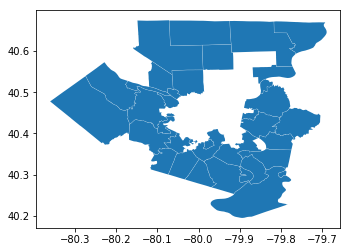

In [76]:
# Just look at high schools
aiu_hs_2015 = aiu_2015[(aiu_2015.gshi>='09')&(aiu_2015.gshi!='KG') & (aiu_2015.gshi!='PK')]
# Inset by ~25 m
aiu_hs_2015_eroded = aiu_hs_2015.geometry.buffer(-0.0003)
aiu_hs_2015_eroded.plot()

In [80]:
try:
    os.unlink('allegheny_county/schools/alvin/schools_aiu_1516-hs.geojson')
except:
    pass
aiu_hs_2015_eroded.to_file('allegheny_county/schools/alvin/schools_aiu_1516-hs.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/schools_aiu_1516-hs.geojson', 
                          'allegheny_county/schools_aiu_1516-hs.bin')

Read 34 features from allegheny_county/schools/alvin/schools_aiu_1516-hs.geojson
47470 segments
Created allegheny_county/schools_aiu_1516-hs.bin (47470 segments)


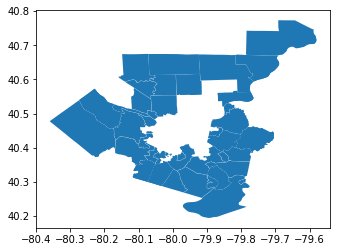

In [77]:
# Just look at middle schools
aiu_ms_2015 = aiu_2015[((aiu_2015.gshi>='06')&(aiu_2015.gshi!='KG') & (aiu_2015.gshi!='PK'))&(aiu_2015.gslo<='08')]
# Inset by ~25 m
aiu_ms_2015_eroded = aiu_ms_2015.geometry.buffer(-0.0003)
aiu_ms_2015_eroded.plot()

In [81]:
try:
    os.unlink('allegheny_county/schools/alvin/schools_aiu_1516-ms.geojson')
except:
    pass
aiu_ms_2015_eroded.to_file('allegheny_county/schools/alvin/schools_aiu_1516-ms.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/schools_aiu_1516-ms.geojson', 
                          'allegheny_county/schools_aiu_1516-ms.bin')

Read 48 features from allegheny_county/schools/alvin/schools_aiu_1516-ms.geojson
51566 segments
Created allegheny_county/schools_aiu_1516-ms.bin (51566 segments)


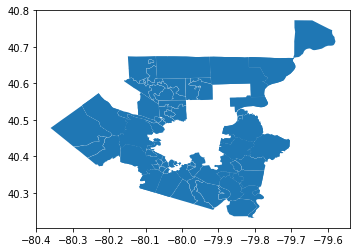

In [78]:
# Just look at elementary schools
aiu_el_2015 = aiu_2015[((aiu_2015.gslo<='05')|(aiu_2015.gslo=='KG') | (aiu_2015.gslo=='PK'))]
# Inset by ~25 m
aiu_el_2015_eroded = aiu_el_2015.geometry.buffer(-0.0003)
aiu_el_2015_eroded.plot()

In [82]:
try:
    os.unlink('allegheny_county/schools/alvin/schools_aiu_1516-el.geojson')
except:
    pass
aiu_el_2015_eroded.to_file('allegheny_county/schools/alvin/schools_aiu_1516-el.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/schools_aiu_1516-el.geojson', 
                          'allegheny_county/schools_aiu_1516-el.bin')

Read 104 features from allegheny_county/schools/alvin/schools_aiu_1516-el.geojson
67323 segments
Created allegheny_county/schools_aiu_1516-el.bin (67323 segments)


# Set up which filter to use

In [419]:
nces_filter_func=nces_filter_aiu

# Enrollment

In [124]:
enrollment_map={}
enrollment_colnames=['School Name','GSLO','GSHI','Latitude','Longitude','Total enrollment','Black enrollment','White enrollment','Asian enrollment','Hispanic enrollment','Other enrollment']

In [348]:
nces_2015_col_remap={'School Name':'SCH_NAME','Zip':'MZIP','Latitude':'LAT1516','Longitude':'LON1516','Total enrollment':'TOTAL',
                     'Black enrollment':'BL','White enrollment':'WH',
                     'Asian enrollment':'AS','Hispanic enrollment':'HI',
                     'LEAID':'LEAID', 'STATUS':'SY_STATUS', 'TYPE':'SCH_TYPE', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO', 'GSHI':'GSHI'}

nces_2014_col_remap={'School Name':'SCH_NAME','Zip':'MZIP','Latitude':'LATCODE','Longitude':'LONGCODE','Total enrollment':'TOTAL',
                     'Black enrollment':'BL','White enrollment':'WH',
                     'Asian enrollment':'AS','Hispanic enrollment':'HI',
                     'LEAID':'LEAID', 'STATUS':'SY_STATUS', 'TYPE':'SCH_TYPE', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO', 'GSHI':'GSHI'
                    }

nces_2013_col_remap={'School Name':'SCHNAM','Zip':'MZIP','Latitude':'LATCOD','Longitude':'LONCOD','Total enrollment':'TOTETH',
                     'Black enrollment':'BLACK','White enrollment':'WHITE',
                     'Asian enrollment':'ASIAN','Hispanic enrollment':'HISP',
                     'LEAID':'LEAID', 'STATUS':'STATUS', 'TYPE':'TYPE', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO', 'GSHI':'GSHI'
                    }

nces_2009_col_remap={'School Name':'SCHNAM09','Zip':'MZIP09','Latitude':'LATCOD09','Longitude':'LONCOD09','Total enrollment':'TOTETH09',
                     'Black enrollment':'BLACK09','White enrollment':'WHITE09',
                     'Asian enrollment':'ASIAN09','Hispanic enrollment':'HISP09',
                     'LEAID':'LEAID', 'STATUS':'STATUS09', 'TYPE':'TYPE09', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO09', 'GSHI':'GSHI09'
                    }

nces_2008_col_remap={'School Name':'SCHNAM08','Zip':'MZIP08','Latitude':'LATCOD08','Longitude':'LONCOD08','Total enrollment':'TOTETH08',
                     'Black enrollment':'BLACK08','White enrollment':'WHITE08',
                     'Asian enrollment':'ASIAN08','Hispanic enrollment':'HISP08',
                     'LEAID':'LEAID', 'STATUS':'STATUS08', 'TYPE':'TYPE08', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO08', 'GSHI':'GSHI08'
                    }

nces_2007_col_remap={'School Name':'SCHNAM07','Zip':'MZIP07','Latitude':'LATCOD07','Longitude':'LONCOD07','Total enrollment':'TOTETH07',
                     'Black enrollment':'BLACK07','White enrollment':'WHITE07',
                     'Asian enrollment':'ASIAN07','Hispanic enrollment':'HISP07',
                     'LEAID':'LEAID', 'STATUS':'STATUS07', 'TYPE':'TYPE07', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO07', 'GSHI':'GSHI07'
                    }

nces_2006_col_remap={'School Name':'SCHNAM06','Zip':'MZIP06','Latitude':'LATCOD06','Longitude':'LONCOD06','Total enrollment':'TOTETH06',
                     'Black enrollment':'BLACK06','White enrollment':'WHITE06',
                     'Asian enrollment':'ASIAN06','Hispanic enrollment':'HISP06',
                     'LEAID':'LEAID', 'STATUS':'STATUS06', 'TYPE':'TYPE06', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO06', 'GSHI':'GSHI06'
                    }

nces_2005_col_remap={'School Name':'SCHNAM05','Zip':'MZIP05','Latitude':'LATCOD05','Longitude':'LONCOD05','Total enrollment':'TOTETH05',
                     'Black enrollment':'BLACK05','White enrollment':'WHITE05',
                     'Asian enrollment':'ASIAN05','Hispanic enrollment':'HISP05',
                     'LEAID':'LEAID', 'STATUS':'STATUS05', 'TYPE':'TYPE05', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO05', 'GSHI':'GSHI05'
                    }

nces_2004_col_remap={'School Name':'SCHNAM04','Zip':'MZIP04','Latitude':'LATCOD04','Longitude':'LONCOD04','Total enrollment':'TOTETH04',
                     'Black enrollment':'BLACK04','White enrollment':'WHITE04',
                     'Asian enrollment':'ASIAN04','Hispanic enrollment':'HISP04',
                     'LEAID':'LEAID', 'STATUS':'STATUS04', 'TYPE':'TYPE04', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO04', 'GSHI':'GSHI04'
                    }

nces_2003_col_remap={'School Name':'SCHNAM03','Zip':'MZIP03','Latitude':'LATCOD03','Longitude':'LONCOD03','Total enrollment':'TOTETH03',
                     'Black enrollment':'BLACK03','White enrollment':'WHITE03',
                     'Asian enrollment':'ASIAN03','Hispanic enrollment':'HISP03',
                     'LEAID':'LEAID', 'STATUS':'STATUS03', 'TYPE':'TYPE03', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO03', 'GSHI':'GSHI03'
                    }

nces_2002_col_remap={'School Name':'SCHNAM02','Zip':'MZIP02','Latitude':'LATCOD02','Longitude':'LONCOD02','Total enrollment':'TOTETH02',
                     'Black enrollment':'BLACK02','White enrollment':'WHITE02',
                     'Asian enrollment':'ASIAN02','Hispanic enrollment':'HISP02',
                     'LEAID':'LEAID', 'STATUS':'STATUS02', 'TYPE':'TYPE02', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO02', 'GSHI':'GSHI02'
                    }

nces_2001_col_remap={'School Name':'SCHNAM01','Zip':'MZIP01','Latitude':'LATCOD01','Longitude':'LONCOD01','Total enrollment':'TOTETH01',
                     'Black enrollment':'BLACK01','White enrollment':'WHITE01',
                     'Asian enrollment':'ASIAN01','Hispanic enrollment':'HISP01',
                     'LEAID':'LEAID', 'STATUS':'STATUS01', 'TYPE':'TYPE01', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO01', 'GSHI':'GSHI01'
                    }

nces_info = {
    '2015':{'col_remap':nces_2015_col_remap, 'path':'allegheny_county/schools/nces/2015-ccd-computed-v2.h5'},
    '2014':{'col_remap':nces_2014_col_remap, 'path':'allegheny_county/schools/nces/2014-ccd-computed-v2.h5'},
    '2013':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2013-ccd-computed.h5'},
    '2012':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2012-ccd-computed.h5'},
    '2011':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2011-ccd-computed.h5'},
    '2010':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2010-ccd-computed.h5'},           
    '2009':{'col_remap':nces_2009_col_remap, 'path':'allegheny_county/schools/nces/2009-ccd-computed.h5'},           
    '2008':{'col_remap':nces_2008_col_remap, 'path':'allegheny_county/schools/nces/2008-ccd-computed.h5'},           
    '2007':{'col_remap':nces_2007_col_remap, 'path':'allegheny_county/schools/nces/2007-ccd-computed.h5'},    
    '2006':{'col_remap':nces_2006_col_remap, 'path':'allegheny_county/schools/nces/2006-ccd-computed-v2.h5'},           
    '2005':{'col_remap':nces_2005_col_remap, 'path':'allegheny_county/schools/nces/2005-ccd-computed-v2.h5'},           
    '2004':{'col_remap':nces_2004_col_remap, 'path':'allegheny_county/schools/nces/2004-ccd-computed-v2.h5'},           
    '2003':{'col_remap':nces_2003_col_remap, 'path':'allegheny_county/schools/nces/2003-ccd-computed-v2.h5'},           
    '2002':{'col_remap':nces_2002_col_remap, 'path':'allegheny_county/schools/nces/2002-ccd-computed-v2.h5'},           
    '2001':{'col_remap':nces_2001_col_remap, 'path':'allegheny_county/schools/nces/2001-ccd-computed-v2.h5'},           
}

In [95]:
def read_nces_hdf(year):
    return pandas.read_hdf(nces_info[year]['path'])

In [392]:
def nces_filter_aiu(df, year):
    col_remap=nces_info[year]['col_remap']
    # Replace any non-numeric values in Zip with 0's, as otherwise it'll choke on letters
    df['COUNTY']=pd.to_numeric(df[col_remap['Zip']], errors='coerce').fillna(0).astype(int).map(zip_to_county)
    # Clean up status and type as well
    #print "Type of STATUS is %s" % (df[col_remap['STATUS']].dtype.name)
    #print "Type of TYPE is %s" % (df[col_remap['TYPE']].dtype.name)
    #print "Type of Total enrollment is %s" % (df[col_remap['Total enrollment']].dtype.name)
    if(df[col_remap['STATUS']].dtype.name=='object'):
        df[col_remap['STATUS']] = df[col_remap['STATUS']].fillna(2).str.replace('[^\d]','0',regex=True).astype(int)
    if(df[col_remap['TYPE']].dtype.name=='object'):
        df[col_remap['TYPE']] = df[col_remap['TYPE']].fillna(2).str.replace('[^\d]','0',regex=True).astype(int)
   
    ret=df[(df.COUNTY=='ALLEGHENY') & (df[col_remap['LEAID']].fillna('').astype(str)!='4219170') & 
           (df[col_remap['STATUS']]!=2)& (df[col_remap['TYPE']]==1) & 
           (pd.to_numeric(df[col_remap['Total enrollment']], errors='coerce')>0)].copy()
    return ret
    

In [ ]:
1300120

In [342]:
def generate_nces_enrollment_df(df, year):
    # Rename to match enrollment_map format
    col_remap=nces_info[year]['col_remap']
    df=df.set_index(col_remap['NCESSCH'])
    df['School Name']=df[col_remap['School Name']]
    df['GSLO']=df[col_remap['GSLO']]
    df['GSHI']=df[col_remap['GSHI']]
    df['Latitude']=pd.to_numeric(df[col_remap['Latitude']], errors='coerce')
    df['Longitude']=pd.to_numeric(df[col_remap['Longitude']], errors='coerce')
    # Starting in 2005 the latitude and longitude are fixed point strings.  Detect this by seeing if latitude off by orders of magnitude
    # Note that this was written for Allegheny Couty, PA, and won't work as well at significantly different latitudes
    div_factor = (10**round(np.log10(df['Latitude'].mean()/40)))
    if(div_factor>=2):
        print "Dividing lat/lon by %f" % (div_factor)
        df['Latitude']=df['Latitude']/div_factor
        df['Longitude']=df['Longitude']/div_factor
    
    df['Black enrollment']=df[col_remap['Black enrollment']].fillna(0).astype(int)
    df['White enrollment']=df[col_remap['White enrollment']].fillna(0).astype(int)
    df['Asian enrollment']=df[col_remap['Asian enrollment']].fillna(0).astype(int)
    df['Hispanic enrollment']=df[col_remap['Hispanic enrollment']].fillna(0).astype(int)
    df['Total enrollment']=df[col_remap['Total enrollment']].fillna(0).astype(int)
    df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
    return df[enrollment_colnames]

In [132]:
def process_aiu_year(year):
    nces_df=read_nces_hdf(year)
    nces_aiu=nces_filter_aiu(nces_df,year)
    enrollment_map[year]=generate_nces_enrollment_df(nces_aiu, year)

In [422]:
def process_year(year):
    print "Processing %s with filter %s" % (year, str(nces_filter_func))
    nces_df=read_nces_hdf(year)
    nces_filt=nces_filter_func(nces_df,year)
    enrollment_map[year]=generate_nces_enrollment_df(nces_filt, year)
    return(nces_filt)                                           

In [424]:
process_year('2001')

Processing 2001 with filter <function nces_filter_aiu at 0x7efe502c1a28>
Processing 2001 with filter <function nces_filter_aiu at 0x7efe502c1a28>
Dividing lat/lon by 1000000.000000
Dividing lat/lon by 1000000.000000


NCESSCH FIPST    LEAID  SCHNO     STID01 SEASCH01  \
7127   420001700336    42  4200017  00336  102023030     7549   
7128   420001800337    42  4200018  00337  102023080     7562   
7129   420001900338    42  4200019  00338  103023090     7563   
7154   420004500411    42  4200045  00411  102023180     7577   
7155   420004600436    42  4200046  00436  103022890     7529   
7173   420006400530    42  4200064  00530  103023410     7648   
7190   420008100595    42  4200081  00595  103020001     7690   
7230   420219000024    42  4202190  00024  103020603     0024   
7231   420219000029    42  4202190  00029  103020603     0029   
7232   420219005296    42  4202190  05296  103020603     5296   
7330   420282000034    42  4202820  00034  103020753     0034   
7331   420282000559    42  4202820  00559  103020753     7669   
7332   420282005199    42  4202820  05199  103020753     5199   
7333   420285000111    42  4202850  00111  103021003     7416   
7334   420285000312    42  4202850  00312  103021003     0312   
7335   420285000313    42  4202850  00313  103021003     0313   
7336   420285000314    42  4202850  00314  103021003     0314   
7337   420285000315    42  4202850  00315  103021003     0315   
7345   420297000037    42  4202970  00037  103021102     0037   
7346   420297000048    42  4202970  00048  103021102     0048   
7347   420297000050    42  4202970  00050  103021102     0050   
7348   420297005194    42  4202970  05194  103021102     5194   
7349   420297006787    42  4202970  06787  103021102     6787   
7406   420351000055    42  4203510  00055  103021252     0055   
7407   420351000060    42  4203510  00060  103021252     0060   
7408   420351000061    42  4203510  00061  103021252     0061   
7409   420351000062    42  4203510  00062  103021252     0062   
7410   420351004802    42  4203510  04802  103021252     4802   
7411   420351004902    42  4203510  04902  103021252     4902   
7412   420351009977    42  4203510  09977  103021252     7326   
...             ...   ...      ...    ...        ...      ...   
9900   422283000261    42  4222830  00261  103028853     7505   
9901   422283000437    42  4222830  00437  103028853     7606   
9902   422283000475    42  4222830  00475  103028853     0475   
9903   422283000477    42  4222830  00477  103028853     0477   
10057  422457000490    42  4224570  00490  103029203     0490   
10058  422457000491    42  4224570  00491  103029203     0491   
10059  422457000492    42  4224570  00492  103029203     0492   
10060  422457004859    42  4224570  04859  103029203     4859   
10061  422457005195    42  4224570  05195  103029203     5195   
10062  422457005196    42  4224570  05196  103029203     5196   
10138  422520000509    42  4225200  00509  103029403     0509   
10139  422520005366    42  4225200  05366  103029403     5366   
10140  422520005367    42  4225200  05367  103029403     5367   
10141  422520006895    42  4225200  06895  103029403     6895   
10164  422559000081    42  4225590  00081  103029553     7382   
10165  422559000516    42  4225590  00516  103029553     0516   
10166  422559000519    42  4225590  00519  103029553     0519   
10167  422559000523    42  4225590  00523  103029553     0523   
10168  422559004867    42  4225590  04867  103029553     4867   
10172  422568000526    42  4225680  00526  103029603     0526   
10173  422568000528    42  4225680  00528  103029603     0528   
10174  422568000532    42  4225680  00532  103029603     0532   
10175  422568000535    42  4225680  00535  103029603     0535   
10176  422568000536    42  4225680  00536  103029603     0536   
10177  422568004953    42  4225680  04953  103029603     4953   
10248  422637000150    42  4226370  00150  103029803     0554   
10249  422637000550    42  4226370  00550  103029803     0550   
10250  422637000553    42  4226370  00553  103029803     0553   
10251  422637000555    42  4226370  00555  103029803     0555   
10252  422637005106    42  4226370  05106  1030

NCESSCH FIPST    LEAID  SCHNO     STID01 SEASCH01  \
7127   420001700336    42  4200017  00336  102023030     7549   
7128   420001800337    42  4200018  00337  102023080     7562   
7129   420001900338    42  4200019  00338  103023090     7563   
7154   420004500411    42  4200045  00411  102023180     7577   
7155   420004600436    42  4200046  00436  103022890     7529   
7173   420006400530    42  4200064  00530  103023410     7648   
7190   420008100595    42  4200081  00595  103020001     7690   
7230   420219000024    42  4202190  00024  103020603     0024   
7231   420219000029    42  4202190  00029  103020603     0029   
7232   420219005296    42  4202190  05296  103020603     5296   
7330   420282000034    42  4202820  00034  103020753     0034   
7331   420282000559    42  4202820  00559  103020753     7669   
7332   420282005199    42  4202820  05199  103020753     5199   
7333   420285000111    42  4202850  00111  103021003     7416   
7334   420285000312    42  4202850  00312  103021003     0312   
7335   420285000313    42  4202850  00313  103021003     0313   
7336   420285000314    42  4202850  00314  103021003     0314   
7337   420285000315    42  4202850  00315  103021003     0315   
7345   420297000037    42  4202970  00037  103021102     0037   
7346   420297000048    42  4202970  00048  103021102     0048   
7347   420297000050    42  4202970  00050  103021102     0050   
7348   420297005194    42  4202970  05194  103021102     5194   
7349   420297006787    42  4202970  06787  103021102     6787   
7406   420351000055    42  4203510  00055  103021252     0055   
7407   420351000060    42  4203510  00060  103021252     0060   
7408   420351000061    42  4203510  00061  103021252     0061   
7409   420351000062    42  4203510  00062  103021252     0062   
7410   420351004802    42  4203510  04802  103021252     4802   
7411   420351004902    42  4203510  04902  103021252     4902   
7412   420351009977    42  4203510  09977  103021252     7326   
...             ...   ...      ...    ...        ...      ...   
9900   422283000261    42  4222830  00261  103028853     7505   
9901   422283000437    42  4222830  00437  103028853     7606   
9902   422283000475    42  4222830  00475  103028853     0475   
9903   422283000477    42  4222830  00477  103028853     0477   
10057  422457000490    42  4224570  00490  103029203     0490   
10058  422457000491    42  4224570  00491  103029203     0491   
10059  422457000492    42  4224570  00492  103029203     0492   
10060  422457004859    42  4224570  04859  103029203     4859   
10061  422457005195    42  4224570  05195  103029203     5195   
10062  422457005196    42  4224570  05196  103029203     5196   
10138  422520000509    42  4225200  00509  103029403     0509   
10139  422520005366    42  4225200  05366  103029403     5366   
10140  422520005367    42  4225200  05367  103029403     5367   
10141  422520006895    42  4225200  06895  103029403     6895   
10164  422559000081    42  4225590  00081  103029553     7382   
10165  422559000516    42  4225590  00516  103029553     0516   
10166  422559000519    42  4225590  00519  103029553     0519   
10167  422559000523    42  4225590  00523  103029553     0523   
10168  422559004867    42  4225590  04867  103029553     4867   
10172  422568000526    42  4225680  00526  103029603     0526   
10173  422568000528    42  4225680  00528  103029603     0528   
10174  422568000532    42  4225680  00532  103029603     0532   
10175  422568000535    42  4225680  00535  103029603     0535   
10176  422568000536    42  4225680  00536  103029603     0536   
10177  422568004953    42  4225680  04953  103029603     4953   
10248  422637000150    42  4226370  00150  103029803     0554   
10249  422637000550    42  4226370  00550  103029803     0550   
10250  422637000553    42  4226370  00553  103029803     0553   
10251  422637000555    42  4226370  00555  103029803     0555   
10252  422637005106    42  4226370  05106  1030

### 2001

In [376]:
process_aiu_year('2001')
enrollment_map['2001']

Type of STATUS is object
Type of TYPE is object
Type of Total enrollment is object
Dividing lat/lon by 1000000.000000


School Name GSLO GSHI   Latitude  Longitude  \
NCESSCH                                                                        
420001700336          MANCHESTER ACADEMIC CS   KG   08  40.455891 -80.023251   
420001800337     NORTHSIDE URBAN PATHWAYS CS   06   12  40.438721 -80.001733   
420001900338   URBAN LEAGUE OF PITTSBURGH CS   KG   05  40.466380 -79.929446   
420004500411          CAREER CONNECTIONS CHS   09   11  40.471433 -79.959605   
420004600436       THURGOOD MARSHALL ACAD CS   KG   11  40.441876 -79.884017   
420006400530                     SPECTRUM CS   UG   UG        NaN        NaN   
420008100595  PA LEARNERS ONLINE REGIONAL CY   KG   12        NaN        NaN   
420219000024             COLFAX UPPER EL SCH   04   06  40.544667 -79.783700   
420219000029                 SPRINGDALE JSHS   07   12  40.545928 -79.778220   
420219005296           ACMETONIA PRIMARY SCH   KG   03  40.543925 -79.816438   
420282000034                AVONWORTH EL SCH   KG   05  40.540973 -80.095468   
420282000559                    AVONWORTH MS   06   08  40.530108 -80.076212   
420282005199                    AVONWORTH HS   09   12  40.530582 -80.077342   
420285000111                 RICHLAND EL SCH   KG   05  40.651102 -79.943948   
420285000312                    HANCE EL SCH   KG   05  40.630445 -79.947013   
420285000313                  WEXFORD EL SCH   KG   05  40.622029 -80.050923   
420285000314                PINE-RICHLAND MS   06   08        NaN        NaN   
420285000315                PINE-RICHLAND HS   09   12  40.659788 -79.978675   
420297000037                MCANNULTY EL SCH   KG   02  40.345671 -79.996524   
420297000048                WHITEHALL EL SCH   03   05  40.353091 -79.992712   
420297000050                     BALDWIN SHS   09   12  40.354440 -79.978628   
420297005194                  PAYNTER EL SCH   KG   05  40.381853 -79.951424   
420297006787                     HARRISON MS   06   08  40.351105 -80.002837   
420351000055          BETHEL MEMORIAL EL SCH   KG   04  40.323886 -80.054333   
420351000060             WILLIAM PENN EL SCH   KG   04  40.298857 -80.044620   
420351000061                 INDEPENDENCE MS   07   08  40.340186 -80.041676   
420351000062                 BETHEL PARK SHS   09   12  40.335888 -80.044356   
420351004802          ABRAHAM LINCOLN EL SCH   KG   04  40.356134 -80.016028   
420351004902        GEORGE WASHINGTON EL SCH   KG   04  40.311658 -80.063768   
420351009977        BENJAMIN FRANKLIN EL SCH   KG   04  40.324524 -80.030835   
...                                      ...  ...  ...        ...        ...   
422283000261                  STO-ROX EL SCH   01   06  40.494761 -80.096810   
422283000437                      STO-ROX MS   07   08        NaN        NaN   
422283000475         FOSTER KINDERGARTEN CTR   KG   KG  40.472266 -80.074976   
422283000477                      STO-ROX HS   09   12        NaN        NaN   
422457000490               EISENHOWER EL SCH   KG   04  40.348590 -80.062405   
422457000491                   FORT COUCH MS   07   08  40.354861 -80.064462   
422457000492            UPPER SAINT CLAIR HS   09   12  40.332997 -80.070397   
422457004859                  STREAMS EL SCH   KG   04  40.324454 -80.092932   
422457005195                    BAKER EL SCH   KG   04  40.336946 -80.095685   
422457005196                        BOYCE MS   05   06  40.314803 -80.099793   
422520000509              WEST ALLEGHENY SHS   09   12  40.445106 -80.235087   
422520005366                    MCKEE EL SCH   KG   05  40.420829 -80.201292   
422520005367                   WILSON EL SCH   KG   05        NaN        NaN   
422520006895               WEST ALLEGHENY MS   06   08  40.445233 -80.234910   
422559000081                JEFFERSON EL SCH   PK   05        NaN        NaN   
422559000516                GILL HALL EL SCH   KG   05        NaN        NaN   
422559000519                MCCLELLAN EL SCH   KG   05        NaN        NaN   
422559000523             THOMAS J

### 2002

In [378]:
process_aiu_year('2002')
enrollment_map['2002']

Dividing lat/lon by 1000000.000000


School Name GSLO GSHI   Latitude  Longitude  \
NCESSCH                                                                        
420001700336          MANCHESTER ACADEMIC CS   KG   08  40.455891 -80.023251   
420001800337     NORTHSIDE URBAN PATHWAYS CS   06   12  40.444126 -79.997459   
420001900338   URBAN LEAGUE OF PITTSBURGH CS   KG   05  40.466380 -79.929446   
420004500411          CAREER CONNECTIONS CHS   09   12  40.471433 -79.959605   
420006400530                     SPECTRUM CS   UG   UG  40.433958 -79.752200   
420008100595  PA LEARNERS ONLINE REGIONAL CY   01   12        NaN        NaN   
420009400663                        CITY CHS   09   09  40.443142 -79.998856   
420219000024             COLFAX UPPER EL SCH   04   06  40.544675 -79.783126   
420219000029                 SPRINGDALE JSHS   07   12  40.545928 -79.778220   
420219005296           ACMETONIA PRIMARY SCH   KG   03  40.543925 -79.816438   
420282000034                AVONWORTH EL SCH   KG   05  40.540973 -80.095468   
420282000559                    AVONWORTH MS   06   08  40.530550 -80.077278   
420282005199                    AVONWORTH HS   09   12  40.529767 -80.075447   
420285000111                 RICHLAND EL SCH   KG   05  40.652454 -79.946700   
420285000312                    HANCE EL SCH   KG   05  40.630445 -79.947013   
420285000313                  WEXFORD EL SCH   KG   05  40.622029 -80.050923   
420285000314                PINE-RICHLAND MS   06   08        NaN        NaN   
420285000315                PINE-RICHLAND HS   09   12  40.659788 -79.978675   
420297000037                MCANNULTY EL SCH   KG   02  40.345671 -79.996524   
420297000048                WHITEHALL EL SCH   03   05  40.353091 -79.992712   
420297000050                     BALDWIN SHS   09   12  40.354440 -79.978628   
420297005194                  PAYNTER EL SCH   KG   05  40.381853 -79.951424   
420297006787                     HARRISON MS   06   08  40.351105 -80.002837   
420351000055          BETHEL MEMORIAL EL SCH   KG   04  40.323886 -80.054333   
420351000060             WILLIAM PENN EL SCH   KG   04  40.298857 -80.044620   
420351000061                 INDEPENDENCE MS   07   08  40.340186 -80.041676   
420351000062                 BETHEL PARK SHS   09   12  40.335888 -80.044356   
420351004802          ABRAHAM LINCOLN EL SCH   KG   04  40.356987 -80.016070   
420351004902        GEORGE WASHINGTON EL SCH   KG   04  40.311658 -80.063768   
420351009977        BENJAMIN FRANKLIN EL SCH   KG   04  40.324524 -80.030835   
...                                      ...  ...  ...        ...        ...   
422283000261                  STO-ROX EL SCH   01   05  40.494761 -80.096810   
422283000437                      STO-ROX MS   06   08  40.494713 -80.096810   
422283000475         FOSTER KINDERGARTEN CTR   KG   KG  40.472266 -80.074976   
422283000477                      STO-ROX HS   09   12        NaN        NaN   
422457000490               EISENHOWER EL SCH   KG   04  40.348590 -80.062405   
422457000491                   FORT COUCH MS   07   08  40.354861 -80.064462   
422457000492            UPPER SAINT CLAIR HS   09   12  40.332997 -80.070397   
422457004859                  STREAMS EL SCH   KG   04  40.324454 -80.092932   
422457005195                    BAKER EL SCH   KG   04  40.336946 -80.095685   
422457005196                        BOYCE MS   05   06  40.314803 -80.099793   
422520000509              WEST ALLEGHENY SHS   09   12  40.445106 -80.235095   
422520005366                    MCKEE EL SCH   KG   05  40.420829 -80.201292   
422520005367                   WILSON EL SCH   KG   05        NaN        NaN   
422520006895               WEST ALLEGHENY MS   06   08  40.445229 -80.234918   
422559000081                JEFFERSON EL SCH   KG   05  40.301456 -79.939917   
422559000516                GILL HALL EL SCH   KG   05  40.302378 -79.961872   
422559000519                MCCLELLAN EL SCH   KG   05        NaN        NaN   
422559000523             THOMAS J

### 2003

In [379]:
process_aiu_year('2003')
enrollment_map['2003']

Dividing lat/lon by 1000000.000000


School Name GSLO GSHI   Latitude  Longitude  \
NCESSCH                                                                        
420001700336          MANCHESTER ACADEMIC CS   KG   08  40.455891 -80.023251   
420001800337     NORTHSIDE URBAN PATHWAYS CS   06   12  40.444126 -79.997459   
420001900338   URBAN LEAGUE OF PITTSBURGH CS   KG   05  40.466380 -79.929446   
420004500411          CAREER CONNECTIONS CHS   09   12  40.471433 -79.959605   
420006400530                     SPECTRUM CS   UG   UG  40.433958 -79.752200   
420008100595  PA LEARNERS ONLINE REGIONAL CY   KG   12        NaN        NaN   
420009400663                        CITY CHS   09   10  40.443142 -79.998856   
420011100749             PROPEL CS-HOMESTEAD   KG   04        NaN        NaN   
420011300711                 RAPAH-EDISON CS   KG   04        NaN        NaN   
420219000024             COLFAX UPPER EL SCH   04   06  40.544675 -79.783126   
420219000029                 SPRINGDALE JSHS   07   12  40.545928 -79.778220   
420219005296           ACMETONIA PRIMARY SCH   KG   03  40.543925 -79.816438   
420282000034                AVONWORTH EL SCH   KG   05  40.540973 -80.095468   
420282000559                    AVONWORTH MS   06   08  40.530550 -80.077278   
420282005199                    AVONWORTH HS   09   12  40.529767 -80.075447   
420285000111                 RICHLAND EL SCH   KG   05  40.652454 -79.946700   
420285000312                    HANCE EL SCH   KG   05  40.630445 -79.947013   
420285000313                  WEXFORD EL SCH   KG   05  40.622029 -80.050923   
420285000314                PINE-RICHLAND MS   06   08        NaN        NaN   
420285000315                PINE-RICHLAND HS   09   12  40.659788 -79.978675   
420297000037                MCANNULTY EL SCH   KG   02  40.345671 -79.996524   
420297000048                WHITEHALL EL SCH   03   05  40.353091 -79.992712   
420297000050                     BALDWIN SHS   09   12  40.354440 -79.978628   
420297005194                  PAYNTER EL SCH   KG   05  40.381853 -79.951424   
420297006787                     HARRISON MS   06   08  40.351105 -80.002837   
420351000055          BETHEL MEMORIAL EL SCH   KG   04  40.323886 -80.054333   
420351000060             WILLIAM PENN EL SCH   KG   04  40.298857 -80.044620   
420351000061                 INDEPENDENCE MS   07   08  40.340186 -80.041676   
420351000062                 BETHEL PARK SHS   09   12  40.335888 -80.044356   
420351004802          ABRAHAM LINCOLN EL SCH   KG   04  40.356987 -80.016070   
...                                      ...  ...  ...        ...        ...   
422283000437                      STO-ROX MS   06   08  40.494713 -80.096810   
422283000475         FOSTER KINDERGARTEN CTR   KG   KG  40.472266 -80.074976   
422283000477                      STO-ROX HS   09   12        NaN        NaN   
422457000490               EISENHOWER EL SCH   KG   04  40.348590 -80.062405   
422457000491                   FORT COUCH MS   07   08  40.354861 -80.064462   
422457000492            UPPER SAINT CLAIR HS   09   12  40.332997 -80.070397   
422457004859                  STREAMS EL SCH   KG   04  40.324454 -80.092932   
422457005195                    BAKER EL SCH   KG   04  40.336946 -80.095685   
422457005196                        BOYCE MS   05   06  40.314803 -80.099793   
422520000509              WEST ALLEGHENY SHS   09   12  40.445106 -80.235095   
422520000707              DONALDSON ELEM SCH   KG   05  40.422680 -80.235099   
422520005366                    MCKEE EL SCH   KG   05  40.420829 -80.201292   
422520005367                   WILSON EL SCH   KG   05        NaN        NaN   
422520006895               WEST ALLEGHENY MS   06   08  40.445229 -80.234918   
422559000081                JEFFERSON EL SCH   KG   05  40.301456 -79.939917   
422559000516                GILL HALL EL SCH   KG   05  40.302378 -79.961872   
422559000519                MCCLELLAN EL SCH   KG   05  40.393746 -79.884101   
422559000523             THOMAS J

### 2004

In [380]:
process_aiu_year('2004')
enrollment_map['2004']

Dividing lat/lon by 1000000.000000


School Name GSLO GSHI   Latitude  Longitude  \
NCESSCH                                                                        
420001700336          MANCHESTER ACADEMIC CS   KG   08  40.455500 -80.023940   
420001800337     NORTHSIDE URBAN PATHWAYS CS   06   12  40.443800 -79.997880   
420001900338   URBAN LEAGUE OF PITTSBURGH CS   KG   05  40.466120 -79.929090   
420004500411          CAREER CONNECTIONS CHS   09   12  40.471920 -79.959440   
420006400530                     SPECTRUM CS   10   11  40.441400 -79.753660   
420008100595  PA LEARNERS ONLINE REGIONAL CY   KG   12  40.413170 -79.907780   
420009400663                        CITY CHS   09   11  40.442610 -79.999160   
420011100749             PROPEL CS-HOMESTEAD   KG   06  40.431169 -79.979974   
420011300711  RENAISSANCE ACAD PGH ALT OF HO   KG   05  40.468400 -79.916900   
420219000024             COLFAX UPPER EL SCH   04   06  40.544450 -79.784120   
420219000029                 SPRINGDALE JSHS   07   12  40.546640 -79.779660   
420219005296           ACMETONIA PRIMARY SCH   KG   03  40.543780 -79.816310   
420282000034                AVONWORTH EL SCH   KG   05  40.539890 -80.094890   
420282000559                    AVONWORTH MS   06   08  40.530480 -80.077190   
420282005199                    AVONWORTH HS   09   12  40.530480 -80.077190   
420285000111                 RICHLAND EL SCH   KG   05  40.657780 -79.959370   
420285000312                    HANCE EL SCH   KG   05  40.629650 -79.946430   
420285000313                  WEXFORD EL SCH   KG   05  40.621650 -80.052370   
420285000314                PINE-RICHLAND MS   06   08  40.643320 -80.006880   
420285000315                PINE-RICHLAND HS   09   12  40.677470 -80.035190   
420297000037                MCANNULTY EL SCH   KG   02  40.352600 -79.992900   
420297000048                WHITEHALL EL SCH   03   05  40.352600 -79.992900   
420297000050                     BALDWIN SHS   09   12  40.355850 -79.979800   
420297005194                  PAYNTER EL SCH   KG   05  40.381960 -79.951510   
420297006787                     HARRISON MS   06   08  40.351140 -80.002600   
420351000055          BETHEL MEMORIAL EL SCH   KG   04  40.323940 -80.055020   
420351000060             WILLIAM PENN EL SCH   KG   04  40.299030 -80.045190   
420351000061                 INDEPENDENCE MS   07   08  40.338890 -80.044610   
420351000062                 BETHEL PARK SHS   09   12  40.331850 -80.043090   
420351004802          ABRAHAM LINCOLN EL SCH   KG   04  40.355790 -80.016140   
...                                      ...  ...  ...        ...        ...   
422283000437                      STO-ROX MS   06   08  40.470800 -80.074400   
422283000475         FOSTER KINDERGARTEN CTR   KG   KG  40.472800 -80.076200   
422283000477                      STO-ROX HS   09   12  40.494300 -80.096200   
422457000490               EISENHOWER EL SCH   KG   04  40.348300 -80.063230   
422457000491                   FORT COUCH MS   07   08  40.355080 -80.064560   
422457000492            UPPER SAINT CLAIR HS   09   12  40.334250 -80.071710   
422457004859                  STREAMS EL SCH   KG   04  40.324270 -80.093390   
422457005195                    BAKER EL SCH   KG   04  40.332510 -80.095180   
422457005196                        BOYCE MS   05   06  40.314920 -80.099600   
422520000509              WEST ALLEGHENY SHS   09   12  40.447170 -80.233590   
422520000707              DONALDSON ELEM SCH   KG   05  40.419700 -80.191100   
422520005366                    MCKEE EL SCH   KG   05  40.428550 -80.203260   
422520005367                   WILSON EL SCH   KG   05  40.442340 -80.267790   
422520006895               WEST ALLEGHENY MS   06   08  40.447170 -80.233590   
422559000081                JEFFERSON EL SCH   KG   05  40.297670 -79.935710   
422559000516                GILL HALL EL SCH   KG   05  40.302720 -79.962090   
422559000519                MCCLELLAN EL SCH   KG   05  40.330510 -79.970010   
422559000523             THOMAS J

### 2005

In [381]:
process_aiu_year('2005')
enrollment_map['2005']

Dividing lat/lon by 1000000.000000


School Name GSLO GSHI  Latitude  Longitude  \
NCESSCH                                                                       
420001700336          MANCHESTER ACADEMIC CS   KG   08  40.45589  -80.02325   
420001800337     NORTHSIDE URBAN PATHWAYS CS   06   12  40.44413  -79.99746   
420001900338   URBAN LEAGUE OF PITTSBURGH CS   KG   05  40.46638  -79.92945   
420004500411          CAREER CONNECTIONS CHS   09   12  40.47143  -79.95961   
420006400530                     SPECTRUM CS   UG   UG  40.43396  -79.75220   
420008100595  PA LEARNERS ONLINE REGIONAL CY   KG   12  40.41274  -79.90215   
420009400663                        CITY CHS   09   12  40.44314  -79.99886   
420011100749             PROPEL CS-HOMESTEAD   KG   07  40.43122  -79.98008   
420011300711  RENAISSANCE ACAD PGH ALT OF HO   KG   05  40.46198  -79.92599   
420013300866                      ACADEMY CS   09   12  40.39930  -79.96810   
420013400867            PROPEL CS-MCKEESPORT   KG   04  40.43120  -79.98050   
420013500869                  PROPEL CS-EAST   KG   04  40.43120  -79.98050   
420219000024             COLFAX UPPER EL SCH   04   06  40.54468  -79.78313   
420219000029                 SPRINGDALE JSHS   07   12  40.54593  -79.77822   
420219005296           ACMETONIA PRIMARY SCH   KG   03  40.54393  -79.81644   
420282000034                AVONWORTH EL SCH   KG   05  40.54097  -80.09547   
420282000559                    AVONWORTH MS   06   08  40.53055  -80.07728   
420282005199                    AVONWORTH HS   09   12  40.52977  -80.07545   
420285000111                 RICHLAND EL SCH   KG   05  40.65245  -79.94670   
420285000312                    HANCE EL SCH   KG   05  40.63045  -79.94701   
420285000313                  WEXFORD EL SCH   KG   05  40.62203  -80.05092   
420285000314                PINE-RICHLAND MS   06   08  40.65532  -80.01288   
420285000315                PINE-RICHLAND HS   09   12  40.65979  -79.97868   
420297000037                MCANNULTY EL SCH   KG   02  40.34567  -79.99652   
420297000048                WHITEHALL EL SCH   03   05  40.35309  -79.99271   
420297000050                     BALDWIN SHS   08   12  40.35444  -79.97863   
420297005194                  PAYNTER EL SCH   KG   05  40.38185  -79.95142   
420297006787                     HARRISON MS   06   08  40.35111  -80.00284   
420351000055          BETHEL MEMORIAL EL SCH   KG   04  40.32389  -80.05433   
420351000060             WILLIAM PENN EL SCH   KG   04  40.29886  -80.04462   
...                                      ...  ...  ...       ...        ...   
422283000437                      STO-ROX MS   06   08  40.49471  -80.09681   
422283000475         FOSTER KINDERGARTEN CTR   KG   KG  40.47227  -80.07498   
422283000477                      STO-ROX HS   09   12  40.47069  -80.07452   
422457000490               EISENHOWER EL SCH   KG   04  40.34859  -80.06241   
422457000491                   FORT COUCH MS   07   08  40.35486  -80.06446   
422457000492            UPPER SAINT CLAIR HS   09   12  40.33300  -80.07040   
422457004859                  STREAMS EL SCH   KG   04  40.32445  -80.09293   
422457005195                    BAKER EL SCH   KG   04  40.33695  -80.09569   
422457005196                        BOYCE MS   05   06  40.31480  -80.09979   
422520000509              WEST ALLEGHENY SHS   09   12  40.44511  -80.23510   
422520000707              DONALDSON ELEM SCH   KG   05  40.42268  -80.23510   
422520005366                    MCKEE EL SCH   KG   05  40.42083  -80.20129   
422520005367                   WILSON EL SCH   KG   05  40.44351  -80.27512   
422520006895               WEST ALLEGHENY MS   06   08  40.44523  -80.23492   
422559000081                JEFFERSON EL SCH   KG   05  40.30146  -79.93992   
422559000516                GILL HALL EL SCH   KG   05  40.30238  -79.96187   
422559000519                MCCLELLAN EL SCH   KG   05  40.39375  -79.88410   
422559000523             THOMAS JEFFERSON HS   09   12  40.31238  -79.95120   
4225

### 2006

In [382]:
process_aiu_year('2006')
enrollment_map['2006']

School Name GSLO GSHI  Latitude  \
NCESSCH                                                                  
420001700336                MANCHESTER ACADEMIC CS   KG   08  40.45589   
420001800337           NORTHSIDE URBAN PATHWAYS CS   06   12  40.44413   
420001900338         URBAN LEAGUE OF PITTSBURGH CS   KG   05  40.46638   
420004500411                CAREER CONNECTIONS CHS   09   12  40.47143   
420008100595  PA LEARNERS ONLINE REGIONAL CYBER CS   KG   12  40.41274   
420009400663                              CITY CHS   09   12  40.44314   
420011100749                   PROPEL CS-HOMESTEAD   KG   08  40.43122   
420011300711   RENAISSANCE ACAD PGH ALT OF HOPE CS   KG   05  40.46198   
420012500839     PENNSYLVANIA DISTANCE LEARNING CS   KG   12  40.25920   
420013300866                            ACADEMY CS   09   12  40.39930   
420013400867                  PROPEL CS-MCKEESPORT   KG   05  40.43120   
420013500869                        PROPEL CS-EAST   KG   05  40.43120   
420219000024                   COLFAX UPPER EL SCH   04   06  40.54468   
420219000029                       SPRINGDALE JSHS   07   12  40.54593   
420219005296                 ACMETONIA PRIMARY SCH   KG   03  40.54393   
420282000034                      AVONWORTH EL SCH   KG   05  40.54097   
420282000559                          AVONWORTH MS   06   08  40.53055   
420282005199                          AVONWORTH HS   09   12  40.52977   
420285000111                       RICHLAND EL SCH   KG   05  40.65245   
420285000312                          HANCE EL SCH   KG   05  40.63045   
420285000313                        WEXFORD EL SCH   KG   05  40.62203   
420285000314                      PINE-RICHLAND MS   06   08  40.65532   
420285000315                      PINE-RICHLAND HS   09   12  40.65979   
420297000037                      MCANNULTY EL SCH   KG   02  40.34567   
420297000048                      WHITEHALL EL SCH   03   05  40.35309   
420297000050                           BALDWIN SHS   09   12  40.35444   
420297005194                        PAYNTER EL SCH   KG   05  40.38185   
420297006787                           HARRISON MS   06   08  40.35111   
420351000055                BETHEL MEMORIAL EL SCH   KG   04  40.32389   
420351000060                   WILLIAM PENN EL SCH   KG   04  40.29886   
...                                            ...  ...  ...       ...   
422283000437                            STO-ROX MS   06   08  40.49471   
422283000475               FOSTER KINDERGARTEN CTR   KG   KG  40.47227   
422283000477                            STO-ROX HS   09   12  40.47069   
422457000490                     EISENHOWER EL SCH   KG   04  40.34859   
422457000491                         FORT COUCH MS   07   08  40.35486   
422457000492                  UPPER SAINT CLAIR HS   09   12  40.33300   
422457004859                        STREAMS EL SCH   KG   04  40.32445   
422457005195                          BAKER EL SCH   KG   04  40.33695   
422457005196                              BOYCE MS   05   06  40.31480   
422520000509                    WEST ALLEGHENY SHS   09   12  40.44511   
422520000707                    DONALDSON ELEM SCH   KG   05  40.42268   
422520005366                          MCKEE EL SCH   KG   05  40.42083   
422520005367                         WILSON EL SCH   KG   05  40.44351   
422520006895                     WEST ALLEGHENY MS   06   08  40.44523   
422559000081                      JEFFERSON EL SCH   KG   05  40.30146   
422559000516                      GILL HALL EL SCH   KG   05  40.30238   
422559000519                      MCCLELLAN EL SCH   KG   05  40.39375   
422559000523                   THOMAS JEFFERSON HS   09   12  40.31238   
422559004867                     PLEASANT HILLS MS   06   08  40.33070   
422568000526                    NEW EMERSON EL SCH   KG   05  40.36198   
422568000528                   CLARA BARTON EL SCH   KG   05  40.34296   
422568000532                      HOMEVILLE

### 2007

In [383]:
process_aiu_year('2007')
enrollment_map['2007']

School Name GSLO GSHI   Latitude  \
NCESSCH                                                                   
420001700336                MANCHESTER ACADEMIC CS   KG   08  40.455890   
420001800337           NORTHSIDE URBAN PATHWAYS CS   06   12  40.444130   
420001900338         URBAN LEAGUE OF PITTSBURGH CS   KG   05  40.466380   
420004500411                CAREER CONNECTIONS CHS   09   12  40.471430   
420008100595  PA LEARNERS ONLINE REGIONAL CYBER CS   KG   12  40.412740   
420009400663                              CITY CHS   09   12  40.443140   
420011100749                   PROPEL CS-HOMESTEAD   KG   08  40.431144   
420012500839     PENNSYLVANIA DISTANCE LEARNING CS   KG   12  40.259200   
420013300866                            ACADEMY CS   09   12  40.399300   
420013400867                  PROPEL CS-MCKEESPORT   KG   06  40.431144   
420013500869                        PROPEL CS-EAST   KG   06  40.431144   
420075206095                     PROPEL CS-MONTOUR   KG   06  40.431298   
420219000024                   COLFAX UPPER EL SCH   04   06  40.544680   
420219000029                       SPRINGDALE JSHS   07   12  40.545930   
420219005296                 ACMETONIA PRIMARY SCH   KG   03  40.543930   
420282000034                      AVONWORTH EL SCH   KG   05  40.540970   
420282000559                          AVONWORTH MS   06   08  40.530550   
420282005199                          AVONWORTH HS   09   12  40.529770   
420285000111                       RICHLAND EL SCH   KG   05  40.652450   
420285000312                          HANCE EL SCH   KG   05  40.630450   
420285000313                        WEXFORD EL SCH   KG   05  40.622030   
420285000314                      PINE-RICHLAND MS   06   08  40.655320   
420285000315                      PINE-RICHLAND HS   09   12  40.659790   
420297000037                      MCANNULTY EL SCH   KG   02  40.345670   
420297000048                      WHITEHALL EL SCH   03   05  40.353090   
420297000050                           BALDWIN SHS   08   12  40.354440   
420297005194                        PAYNTER EL SCH   KG   05  40.381850   
420297006787                           HARRISON MS   06   08  40.351110   
420351000055                BETHEL MEMORIAL EL SCH   KG   04  40.323890   
420351000060                   WILLIAM PENN EL SCH   KG   04  40.298860   
...                                            ...  ...  ...        ...   
422283000475               FOSTER KINDERGARTEN CTR   KG   KG  40.472270   
422283000477                            STO-ROX HS   09   12  40.470690   
422457000490                     EISENHOWER EL SCH   KG   04  40.348590   
422457000491                         FORT COUCH MS   07   08  40.354860   
422457000492                  UPPER SAINT CLAIR HS   09   12  40.333000   
422457004859                        STREAMS EL SCH   KG   04  40.324450   
422457005195                          BAKER EL SCH   KG   04  40.336950   
422457005196                              BOYCE MS   05   06  40.314800   
422520000509                    WEST ALLEGHENY SHS   09   12  40.445110   
422520000707                    DONALDSON ELEM SCH   KG   05  40.422680   
422520005366                          MCKEE EL SCH   KG   05  40.420830   
422520005367                         WILSON EL SCH   KG   05  40.443510   
422520006895                     WEST ALLEGHENY MS   06   08  40.445230   
422559000081                      JEFFERSON EL SCH   KG   05  40.301460   
422559000516                      GILL HALL EL SCH   KG   05  40.302380   
422559000519                      MCCLELLAN EL SCH   KG   05  40.393750   
422559000523                   THOMAS JEFFERSON HS   09   12  40.312380   
422559004867                     PLEASANT HILLS MS   06   08  40.330700   
422568000526                    NEW EMERSON EL SCH   KG   05  40.361980   
422568000528                   CLARA BARTON EL SCH   KG   05  40.342960   
422568000532                      HOMEVILLE EL SCH   KG   05  40

### 2008

In [384]:
process_aiu_year('2008')
enrollment_map['2008']

School Name GSLO GSHI  \
NCESSCH                                                                  
420001700336                          MANCHESTER ACADEMIC CS   KG   08   
420001800337                     NORTHSIDE URBAN PATHWAYS CS   06   12   
420001900338                   URBAN LEAGUE OF PITTSBURGH CS   KG   05   
420004500411                          CAREER CONNECTIONS CHS   09   12   
420008100595            PA LEARNERS ONLINE REGIONAL CYBER CS   KG   12   
420009400663                                        CITY CHS   09   12   
420011100749                             PROPEL CS-HOMESTEAD   KG   09   
420012500839               PENNSYLVANIA DISTANCE LEARNING CS   KG   12   
420013300866                                      ACADEMY CS   09   12   
420013400867                            PROPEL CS-MCKEESPORT   KG   07   
420013500869                                  PROPEL CS-EAST   KG   07   
420075206095                               PROPEL CS-MONTOUR   KG   07   
420081206819  THE ENVIRONMENTAL CHARTER SCHOOL AT FRICK PARK   KG   03   
420219000024                             COLFAX UPPER EL SCH   04   06   
420219000029                                 SPRINGDALE JSHS   07   12   
420219005296                           ACMETONIA PRIMARY SCH   KG   03   
420282000034                                AVONWORTH EL SCH   KG   05   
420282000559                                    AVONWORTH MS   06   08   
420282005199                                    AVONWORTH HS   09   12   
420285000111                                 RICHLAND EL SCH   KG   03   
420285000312                                    HANCE EL SCH   KG   03   
420285000313                                  WEXFORD EL SCH   KG   03   
420285000314                                PINE-RICHLAND MS   07   08   
420285000315                                PINE-RICHLAND HS   09   12   
420285006816                          EDEN HALL UPPER EL SCH   04   06   
420297000037                                MCANNULTY EL SCH   KG   02   
420297000048                                WHITEHALL EL SCH   03   05   
420297000050                                     BALDWIN SHS   08   12   
420297005194                                  PAYNTER EL SCH   KG   05   
420297006787                                     HARRISON MS   06   08   
...                                                      ...  ...  ...   
422283000475                         FOSTER KINDERGARTEN CTR   KG   KG   
422283000477                                      STO-ROX HS   09   12   
422457000490                               EISENHOWER EL SCH   KG   04   
422457000491                                   FORT COUCH MS   07   08   
422457000492                            UPPER SAINT CLAIR HS   09   12   
422457004859                                  STREAMS EL SCH   KG   04   
422457005195                                    BAKER EL SCH   KG   04   
422457005196                                        BOYCE MS   05   06   
422520000509                              WEST ALLEGHENY SHS   09   12   
422520000707                              DONALDSON ELEM SCH   KG   05   
422520005366                                    MCKEE EL SCH   KG   05   
422520005367                                   WILSON EL SCH   KG   05   
422520006895                               WEST ALLEGHENY MS   06   08   
422559000081                                JEFFERSON EL SCH   KG   05   
422559000516                                GILL HALL EL SCH   KG   05   
422559000519                                MCCLELLAN EL SCH   KG   05   
422559000523                             THOMAS JEFFERSON HS   09   12   
422559004867                               PLEASANT HILLS MS   06   08   
422568000526                              NEW EMERSON EL SCH   KG   05   
422568000528                             CLARA BARTON EL SCH   KG   05   
422568000532                                HOMEVILLE EL SCH   KG   05   
422568000535                            WEST MIFFLIN 

### 2009

In [385]:
process_aiu_year('2009')
enrollment_map['2009']

School Name GSLO GSHI   Latitude  \
NCESSCH                                                                         
420001700336                      MANCHESTER ACADEMIC CS   KG   08  40.455695   
420001800337                 NORTHSIDE URBAN PATHWAYS CS   06   12  40.443788   
420001900338               URBAN LEAGUE OF PITTSBURGH CS   KG   05  40.466064   
420004500411                      CAREER CONNECTIONS CHS   09   12  40.471636   
420008100595        PA LEARNERS ONLINE REGIONAL CYBER CS   KG   12  40.412519   
420009400663                                    CITY CHS   09   12  40.442624   
420011100749                         PROPEL CS-HOMESTEAD   KG   11  40.405315   
420012500839           PENNSYLVANIA DISTANCE LEARNING CS   KG   12  40.610441   
420013300866                                  ACADEMY CS   09   12  40.399343   
420013400867                        PROPEL CS-MCKEESPORT   KG   08  40.345626   
420013500869                              PROPEL CS-EAST   KG   08  40.409195   
420075206095                           PROPEL CS-MONTOUR   KG   08  40.454373   
420081206819  ENVIRONMENTAL CHARTER SCHOOL AT FRICK PARK   KG   04  40.436046   
420219000024                         COLFAX UPPER EL SCH   04   06  40.544310   
420219000029                             SPRINGDALE JSHS   07   12  40.548136   
420219005296                       ACMETONIA PRIMARY SCH   KG   03  40.543433   
420282000034                            AVONWORTH EL SCH   KG   05  40.539602   
420282000559                                AVONWORTH MS   06   08  40.530421   
420282005199                                AVONWORTH HS   09   12  40.529894   
420285000111                             RICHLAND EL SCH   KG   03  40.657521   
420285000312                                HANCE EL SCH   KG   03  40.630291   
420285000313                              WEXFORD EL SCH   KG   03  40.621756   
420285000314                            PINE-RICHLAND MS   07   08  40.655217   
420285000315                            PINE-RICHLAND HS   09   12  40.682083   
420285006816                      EDEN HALL UPPER EL SCH   04   06  40.657665   
420297000037                            MCANNULTY EL SCH   KG   01  40.345724   
420297000048                            WHITEHALL EL SCH   02   05  40.354314   
420297000050                                 BALDWIN SHS   08   12  40.355883   
420297005194                              PAYNTER EL SCH   KG   05  40.381982   
420297006787                                 HARRISON MS   06   08  40.351380   
...                                                  ...  ...  ...        ...   
422283000437                                  STO-ROX MS   05   08  40.483701   
422283000477                                  STO-ROX HS   09   12  40.471222   
422457000490                           EISENHOWER EL SCH   KG   04  40.348218   
422457000491                               FORT COUCH MS   07   08  40.354668   
422457000492                        UPPER SAINT CLAIR HS   09   12  40.334183   
422457004859                              STREAMS EL SCH   KG   04  40.324237   
422457005195                                BAKER EL SCH   KG   04  40.337295   
422457005196                                    BOYCE MS   05   06  40.315239   
422520000509                          WEST ALLEGHENY SHS   09   12  40.447478   
422520000707                          DONALDSON ELEM SCH   KG   05  40.421383   
422520005366                                MCKEE EL SCH   KG   05  40.413445   
422520005367                               WILSON EL SCH   KG   05  40.444718   
422520006895                           WEST ALLEGHENY MS   06   08  40.447643   
422559000081                            JEFFERSON EL SCH   KG   05  40.296670   
422559000516                            GILL HALL EL SCH   KG   05  40.302578   
422559000519                            MCCLELLAN EL SCH   KG   05  40.330593   
422559000523                         THOMAS JEFFERSON HS   09   12  40.29627

### 2010

In [386]:
process_aiu_year('2010')
enrollment_map['2010']

School Name GSLO GSHI   Latitude  \
NCESSCH                                                                         
420001700336                      MANCHESTER ACADEMIC CS   KG   08  40.455545   
420001800337                 NORTHSIDE URBAN PATHWAYS CS   06   12  40.444212   
420001900338       URBAN LEAGUE OF GREATER PITTSBURGH CS   KG   05  40.466004   
420004500411                      CAREER CONNECTIONS CHS   09   12  40.471624   
420008100595        PA LEARNERS ONLINE REGIONAL CYBER CS   KG   12  40.412519   
420009400663                                    CITY CHS   09   12  40.442650   
420011100749                         PROPEL CS-HOMESTEAD   KG   12  40.405252   
420012500839           PENNSYLVANIA DISTANCE LEARNING CS   KG   12  40.610441   
420013300866                                  ACADEMY CS   09   12  40.399318   
420013400867                        PROPEL CS-MCKEESPORT   KG   08  40.345601   
420013500869                              PROPEL CS-EAST   KG   08  40.409221   
420075206095                           PROPEL CS-MONTOUR   KG   08  40.454250   
420081206819  ENVIRONMENTAL CHARTER SCHOOL AT FRICK PARK   KG   05  40.436055   
420083307363               PROPEL CHARTER SCHOOL-SUNRISE   KG   10  40.413821   
420219000024                         COLFAX UPPER EL SCH   04   06  40.544313   
420219000029                             SPRINGDALE JSHS   07   12  40.548061   
420219005296                       ACMETONIA PRIMARY SCH   KG   03  40.543439   
420282000034                            AVONWORTH EL SCH   KG   05  40.539606   
420282000559                                AVONWORTH MS   06   08  40.530398   
420282005199                                AVONWORTH HS   09   12  40.529878   
420285000111                             RICHLAND EL SCH   KG   03  40.657723   
420285000312                                HANCE EL SCH   KG   03  40.630295   
420285000313                              WEXFORD EL SCH   KG   03  40.621730   
420285000314                            PINE-RICHLAND MS   07   08  40.655193   
420285000315                            PINE-RICHLAND HS   09   12  40.682105   
420285006816                      EDEN HALL UPPER EL SCH   04   06  40.657690   
420297000037                            MCANNULTY EL SCH   KG   01  40.345724   
420297000048                            WHITEHALL EL SCH   02   05  40.354657   
420297000050                                 BALDWIN SHS   08   12  40.355898   
420297005194                              PAYNTER EL SCH   KG   05  40.381957   
...                                                  ...  ...  ...        ...   
422283000437                                  STO-ROX MS   06   08  40.483707   
422283000477                                  STO-ROX HS   09   12  40.471218   
422457000490                           EISENHOWER EL SCH   KG   04  40.348236   
422457000491                               FORT COUCH MS   07   08  40.354663   
422457000492                        UPPER SAINT CLAIR HS   09   12  40.334203   
422457004859                              STREAMS EL SCH   KG   04  40.324252   
422457005195                                BAKER EL SCH   KG   04  40.337294   
422457005196                                    BOYCE MS   05   06  40.315095   
422520000509                          WEST ALLEGHENY SHS   09   12  40.447494   
422520000707                          DONALDSON ELEM SCH   KG   05  40.421367   
422520005366                                MCKEE EL SCH   KG   05  40.413465   
422520005367                               WILSON EL SCH   KG   05  40.444724   
422520006895                           WEST ALLEGHENY MS   06   08  40.447659   
422559000081                            JEFFERSON EL SCH   KG   05  40.296695   
422559000516                            GILL HALL EL SCH   KG   05  40.302590   
422559000519                            MCCLELLAN EL SCH   KG   05  40.330588   
422559000523                         THOMAS JEFFERSON HS   09   12  40.29611

### 2011

In [387]:
process_aiu_year('2011')
enrollment_map['2011']

School Name GSLO GSHI  \
NCESSCH                                                                  
420001700336                          MANCHESTER ACADEMIC CS   KG   08   
420001800337                     NORTHSIDE URBAN PATHWAYS CS   06   12   
420001900338           URBAN LEAGUE OF GREATER PITTSBURGH CS   KG   05   
420004500411                          CAREER CONNECTIONS CHS   09   12   
420008100595            PA LEARNERS ONLINE REGIONAL CYBER CS   KG   12   
420009400663                                        CITY CHS   09   12   
420011100749                             PROPEL CS-HOMESTEAD   KG   12   
420012500839               PENNSYLVANIA DISTANCE LEARNING CS   KG   12   
420013300866                                      ACADEMY CS   09   12   
420013400867                            PROPEL CS-MCKEESPORT   KG   08   
420013500869                                  PROPEL CS-EAST   KG   08   
420075206095                               PROPEL CS-MONTOUR   KG   08   
420081206819      ENVIRONMENTAL CHARTER SCHOOL AT FRICK PARK   KG   06   
420083307363                        PROPEL CS-BRADDOCK HILLS   KG   12   
420084507424       YOUNG SCHOLARS OF WESTERN PENNSYLVANIA CS   KG   05   
420084707425       URBAN PATHWAYS K-5 COLLEGE CHARTER SCHOOL   KG   03   
420084907380                             PROPEL CS-NORTHSIDE   KG   08   
420085307381  PENN HILLS CHARTER SCHOOL FOR ENTREPRENEURSHIP   KG   02   
420219000024                             COLFAX UPPER EL SCH   04   06   
420219000029                                 SPRINGDALE JSHS   07   12   
420219005296                           ACMETONIA PRIMARY SCH   KG   03   
420282000034                                AVONWORTH EL SCH   KG   05   
420282000559                                    AVONWORTH MS   06   08   
420282005199                                    AVONWORTH HS   09   12   
420285000111                                 RICHLAND EL SCH   KG   03   
420285000312                                    HANCE EL SCH   KG   03   
420285000313                                  WEXFORD EL SCH   KG   03   
420285000314                                PINE-RICHLAND MS   07   08   
420285000315                                PINE-RICHLAND HS   09   12   
420285006816                          EDEN HALL UPPER EL SCH   04   06   
...                                                      ...  ...  ...   
422283000261                                  STO-ROX EL SCH   KG   05   
422283000437                                      STO-ROX MS   06   08   
422283000477                                      STO-ROX HS   09   12   
422457000490                               EISENHOWER EL SCH   KG   04   
422457000491                                   FORT COUCH MS   07   08   
422457000492                            UPPER SAINT CLAIR HS   09   12   
422457004859                                  STREAMS EL SCH   KG   04   
422457005195                                    BAKER EL SCH   KG   04   
422457005196                                        BOYCE MS   05   06   
422520000509                              WEST ALLEGHENY SHS   09   12   
422520000707                              DONALDSON ELEM SCH   KG   05   
422520005366                                    MCKEE EL SCH   KG   05   
422520005367                                   WILSON EL SCH   KG   05   
422520006895                               WEST ALLEGHENY MS   06   08   
422559000081                                JEFFERSON EL SCH   KG   05   
422559000516                                GILL HALL EL SCH   KG   05   
422559000519                                MCCLELLAN EL SCH   KG   05   
422559000523                             THOMAS JEFFERSON HS   09   12   
422559004867                               PLEASANT HILLS MS   06   08   
422568000526                              NEW EMERSON EL SCH   KG   05   
422568000528                             CLARA BARTON EL SCH   KG   05   
422568000532                                HOMEVILLE

### 2012

In [388]:
process_aiu_year('2012')
enrollment_map['2012']

School Name GSLO GSHI   Latitude  \
NCESSCH                                                                       
420001700336                    MANCHESTER ACADEMIC CS   KG   08  40.455790   
420001800337                    URBAN PATHWAYS 6-12 CS   06   12  40.443720   
420001900338     URBAN LEAGUE OF GREATER PITTSBURGH CS   KG   05  40.466240   
420004500411                    CAREER CONNECTIONS CHS   09   12  40.471740   
420008100595      PA LEARNERS ONLINE REGIONAL CYBER CS   KG   12  40.412740   
420009400663                                  CITY CHS   09   12  40.440080   
420011100749                       PROPEL CS-HOMESTEAD   KG   12  40.405280   
420012500839         PENNSYLVANIA DISTANCE LEARNING CS   KG   12  40.610600   
420013300866                                ACADEMY CS   09   12  40.404310   
420013400867                      PROPEL CS-MCKEESPORT   KG   08  40.345440   
420013500869                            PROPEL CS-EAST   KG   08  40.409340   
420075206095                         PROPEL CS-MONTOUR   KG   08  40.454320   
420081206819  ENVIRONMENTAL CHARTER SCHOOL AT FRICK PA   03   03  40.435950   
420083307363                  PROPEL CS-BRADDOCK HILLS   12   12  40.413990   
420084507424  YOUNG SCHOLARS OF WESTERN PENNSYLVANIA C   KG   08  40.376371   
420084707425  URBAN PATHWAYS K-5 COLLEGE CHARTER SCHOO   KG   05  40.444220   
420084907380                       PROPEL CS-NORTHSIDE   KG   08  40.460140   
420085307381  PENN HILLS CHARTER SCHOOL FOR ENTREPRENE   KG   06  40.497800   
420085907427                      PROPEL CS - PITCAIRN   KG   06  40.404160   
420219000024                       COLFAX UPPER EL SCH   04   06  40.544756   
420219000029                           SPRINGDALE JSHS   07   12  40.548140   
420219005296                     ACMETONIA PRIMARY SCH   KG   03  40.545770   
420282000034                          AVONWORTH EL SCH   KG   05  40.542040   
420282000559                              AVONWORTH MS   06   08  40.531110   
420282005199                              AVONWORTH HS   09   12  40.531640   
420285000111                           RICHLAND EL SCH   KG   03  40.656450   
420285000312                              HANCE EL SCH   KG   03  40.628920   
420285000313                            WEXFORD EL SCH   KG   03  40.622420   
420285000314                          PINE-RICHLAND MS   07   08  40.656830   
420285000315                          PINE-RICHLAND HS   09   12  40.658350   
...                                                ...  ...  ...        ...   
422279000260                           STEEL VALLEY MS   06   08  40.388632   
422279007243                      FRANKLIN PRIMARY CTR   KG   KG  40.389820   
422283000261                            STO-ROX EL SCH   KG   05  40.491450   
422283000437                                STO-ROX MS   06   08  40.489801   
422283000477                                STO-ROX HS   09   12  40.470690   
422457000490                         EISENHOWER EL SCH   KG   04  40.349652   
422457000491                             FORT COUCH MS   07   08  40.354250   
422457000492                      UPPER SAINT CLAIR HS   09   12  40.334640   
422457004859                            STREAMS EL SCH   KG   04  40.321957   
422457005195                              BAKER EL SCH   KG   04  40.335900   
422457005196                                  BOYCE MS   05   06  40.315240   
422520000509                        WEST ALLEGHENY SHS   09   12  40.448896   
422520000707                        DONALDSON ELEM SCH   KG   05  40.418215   
422520005366                              MCKEE EL SCH   KG   05  40.415740   
422520005367                             WILSON EL SCH   KG   05  40.444250   
422520006895                         WEST ALLEGHENY MS   06   08  40.448070   
422559000081                          JEFFERSON EL SCH   KG   05  40.301460   
422559000516                          GILL HALL EL SCH   KG   05  40.300814   
422559000519  

### 2013

In [389]:
process_aiu_year('2013')
enrollment_map['2013']

School Name GSLO GSHI  Latitude  \
NCESSCH                                                                      
420001700336                    MANCHESTER ACADEMIC CS   KG   08   40.4568   
420001800337                    URBAN PATHWAYS 6-12 CS   06   12   40.4441   
420001900338     URBAN LEAGUE OF GREATER PITTSBURGH CS   KG   05   40.4664   
420004500411                    CAREER CONNECTIONS CHS   09   12   40.4715   
420009400663                                  CITY CHS   09   12   40.4401   
420011100749                       PROPEL CS-HOMESTEAD   KG   12   40.4053   
420012500839         PENNSYLVANIA DISTANCE LEARNING CS   KG   12   40.6106   
420013300866                                ACADEMY CS   08   12   40.4004   
420013400867                      PROPEL CS-MCKEESPORT   KG   08   40.3454   
420013500869                            PROPEL CS-EAST   KG   08   40.4094   
420075206095                         PROPEL CS-MONTOUR   KG   08   40.4543   
420081206819  ENVIRONMENTAL CHARTER SCHOOL AT FRICK PA   KG   08   40.4360   
420083307363                  PROPEL CS-BRADDOCK HILLS   KG   12   40.4140   
420084507424  YOUNG SCHOLARS OF WESTERN PENNSYLVANIA C   KG   08   40.3764   
420084707425  URBAN PATHWAYS K-5 COLLEGE CHARTER SCHOO   KG   05   40.4442   
420084907380                       PROPEL CS-NORTHSIDE   KG   08   40.4601   
420085307381  PENN HILLS CHARTER SCHOOL FOR ENTREPRENE   KG   06   40.4978   
420085907427                        PROPEL CS-PITCAIRN   KG   08   40.4042   
420219000024                       COLFAX UPPER EL SCH   04   06   40.5448   
420219000029                           SPRINGDALE JSHS   07   12   40.5473   
420219005296                     ACMETONIA PRIMARY SCH   KG   03   40.5454   
420282000034                          AVONWORTH EL SCH   KG   05   40.5416   
420282000559                              AVONWORTH MS   06   08   40.5325   
420282005199                              AVONWORTH HS   09   12   40.5323   
420285000111                           RICHLAND EL SCH   KG   03   40.6536   
420285000312                              HANCE EL SCH   KG   03   40.6282   
420285000313                            WEXFORD EL SCH   KG   03   40.6230   
420285000314                          PINE-RICHLAND MS   07   08   40.6565   
420285000315                          PINE-RICHLAND HS   09   12   40.6584   
420285006816                    EDEN HALL UPPER EL SCH   04   06   40.6577   
...                                                ...  ...  ...       ...   
422279000260                           STEEL VALLEY MS   06   08   40.3886   
422279007243                      FRANKLIN PRIMARY CTR   KG   KG   40.3898   
422283000261                            STO-ROX EL SCH   KG   05   40.4921   
422283000437                                STO-ROX MS   06   08   40.4898   
422283000477                                STO-ROX HS   09   12   40.4707   
422457000490                         EISENHOWER EL SCH   KG   04   40.3497   
422457000491                             FORT COUCH MS   07   08   40.3543   
422457000492                      UPPER SAINT CLAIR HS   09   12   40.3348   
422457004859                            STREAMS EL SCH   KG   04   40.3220   
422457005195                              BAKER EL SCH   KG   04   40.3351   
422457005196                                  BOYCE MS   05   06   40.3166   
422520000509                        WEST ALLEGHENY SHS   09   12   40.4489   
422520000707                        DONALDSON ELEM SCH   KG   05   40.4182   
422520005366                              MCKEE EL SCH   KG   05   40.4208   
422520005367                             WILSON EL SCH   KG   05   40.4435   
422520006895                         WEST ALLEGHENY MS   06   08   40.4471   
422559000081                          JEFFERSON EL SCH   KG   05   40.3015   
422559000516                          GILL HALL EL SCH   KG   05   40.3008   
422559000519                          MCCLELLAN EL SCH   KG   05 

### 2014

In [393]:
process_aiu_year('2014')
enrollment_map['2014']

School Name GSLO GSHI   Latitude  \
NCESSCH                                                                       
420001700336                    Manchester Academic CS   KG   08  40.456757   
420001800337                    Urban Pathways 6-12 CS   06   12  40.444130   
420001900338     Urban League of Greater Pittsburgh CS   KG   05  40.466395   
420006400530                               Spectrum CS   07   12  40.433960   
420009400663                                  City CHS   09   12  40.440080   
420011100749                       Propel CS-Homestead   KG   12  40.405319   
420012500839         Pennsylvania Distance Learning CS   KG   12  40.610600   
420013300866                                Academy CS   08   12  40.400353   
420013400867                      Propel CS-McKeesport   KG   08  40.345520   
420013500869                            Propel CS-East   KG   08  40.409368   
420075206095                         Propel CS-Montour   KG   08  40.454320   
420081206819  Environmental Charter School at Frick Pa   KG   08  40.435950   
420083307363                  Propel CS-Braddock Hills   KG   12  40.413990   
420084507424  Young Scholars of Western Pennsylvania C   KG   08  40.376350   
420084707425  Urban Pathways K-5 College Charter Schoo   KG   05  40.444220   
420084907380                       Propel CS-Northside   KG   08  40.460010   
420085307381  Penn Hills Charter School for Entreprene   KG   06  40.497800   
420085907427                        Propel CS-Pitcairn   KG   08  40.404160   
420088007543                     Propel CS - Hazelwood   KG   07  40.403841   
420088207549  Hill House Passport Academy Charter Scho   09   12  40.442732   
420219000024                       Colfax Upper El Sch   04   06  40.544756   
420219000029                           Springdale JSHS   07   12  40.547349   
420219005296                     Acmetonia Primary Sch   KG   03  40.545397   
420282000034                          Avonworth El Sch   03   05  40.541601   
420282000559                              Avonworth MS   06   08  40.532492   
420282005199                              Avonworth HS   09   12  40.532250   
420282007520                  Avonworth Primary Center   KG   02  40.540561   
420285000111                           Richland El Sch   KG   03  40.653577   
420285000312                              Hance El Sch   KG   03  40.628166   
420285000313                            Wexford El Sch   KG   03  40.622974   
...                                                ...  ...  ...        ...   
422279000260                           Steel Valley MS   06   08  40.388632   
422279007243                      Franklin Primary Ctr   KG   KG  40.389600   
422283000261                            Sto-Rox El Sch   KG   05  40.492139   
422283000437                                Sto-Rox MS   06   08  40.489801   
422283000477                                Sto-Rox HS   09   12  40.470690   
422457000490                         Eisenhower El Sch   KG   04  40.349652   
422457000491                             Fort Couch MS   07   08  40.354330   
422457000492                      Upper Saint Clair HS   09   12  40.334800   
422457004859                            Streams El Sch   KG   04  40.321957   
422457005195                              Baker El Sch   KG   04  40.335122   
422457005196                                  Boyce MS   05   06  40.316643   
422520000509                        West Allegheny SHS   09   12  40.448896   
422520000707                        Donaldson Elem Sch   KG   05  40.418215   
422520005366                              McKee El Sch   KG   05  40.420830   
422520005367                             Wilson El Sch   KG   05  40.443510   
422520006895                         West Allegheny MS   06   08  40.447088   
422559000081                          Jefferson El Sch   KG   05  40.301460   
422559000516                          Gill Hall El Sch   KG   05  40.300814   
422559000519  

### 2015

In [394]:
process_aiu_year('2015')
enrollment_map['2015']

School Name GSLO GSHI   Latitude  \
NCESSCH                                                                       
420001700336                    Manchester Academic CS   KG   08  40.456757   
420001800337                    Urban Pathways 6-12 CS   06   12  40.444130   
420001900338    Urban Academy of Greater Pittsburgh CS   KG   05  40.466395   
420006400530                               Spectrum CS   07   12  40.433960   
420009400663                                  City CHS   09   12  40.440080   
420011100749                       Propel CS-Homestead   KG   12  40.405319   
420012500839         Pennsylvania Distance Learning CS   KG   12  40.610600   
420013300866                                Academy CS   08   12  40.400353   
420013400867                      Propel CS-McKeesport   KG   08  40.345520   
420013500869                            Propel CS-East   KG   08  40.409368   
420075206095                         Propel CS-Montour   KG   08  40.454320   
420081206819  Environmental Charter School at Frick Pa   KG   08  40.435950   
420083307363                  Propel CS-Braddock Hills   KG   12  40.413990   
420084507424  Young Scholars of Western Pennsylvania C   KG   08  40.376350   
420084707425  Urban Pathways K-5 College Charter Schoo   KG   05  40.444220   
420084907380                       Propel CS-Northside   KG   08  40.460010   
420085307381  Penn Hills Charter School for Entreprene   KG   06  40.497800   
420085907427                        Propel CS-Pitcairn   KG   08  40.404160   
420088007543                     Propel CS - Hazelwood   KG   07  40.420280   
420088207549  Hill House Passport Academy Charter Scho   09   12  40.442732   
420088407552  Young Scholars of McKeesport Charter Sch   PK   08  40.349648   
420219005296                     Acmetonia Primary Sch   KG   03  40.545397   
420219000029                           Springdale JSHS   07   12  40.547349   
420219000024                       Colfax Upper El Sch   04   06  40.544756   
420282007520                  Avonworth Primary Center   KG   02  40.540561   
420282005199                              Avonworth HS   09   12  40.532250   
420282000559                              Avonworth MS   06   08  40.532492   
420282000034                          Avonworth El Sch   03   05  40.541601   
420285006816                    Eden Hall Upper El Sch   04   06  40.657659   
420285000315                          Pine-Richland HS   09   12  40.658350   
...                                                ...  ...  ...        ...   
422279000196                          Steel Valley SHS   09   12  40.388460   
422279000193                            Barrett El Sch   01   05  40.405113   
422283000477                                Sto-Rox HS   09   12  40.470690   
422283000437                                Sto-Rox MS   06   08  40.489801   
422283000261                            Sto-Rox El Sch   KG   05  40.492139   
422457005196                                  Boyce MS   05   06  40.316643   
422457005195                              Baker El Sch   KG   04  40.335122   
422457004859                            Streams El Sch   KG   04  40.321957   
422457000492                      Upper Saint Clair HS   09   12  40.334800   
422457000491                             Fort Couch MS   07   08  40.354330   
422457000490                         Eisenhower El Sch   KG   04  40.349652   
422520006895                         West Allegheny MS   06   08  40.447088   
422520005367                             Wilson El Sch   KG   05  40.443510   
422520005366                              McKee El Sch   KG   05  40.420830   
422520000707                        Donaldson Elem Sch   KG   05  40.418215   
422520000509                        West Allegheny SHS   09   12  40.448896   
422559004867                         Pleasant Hills MS   06   08  40.330421   
422559000523                       Thomas Jefferson HS   09   12  40.312400   
422559000519  

# Consistency check on enrollment_map

In [407]:
ncessch_to_latlon_map={}
ncessch_yr_to_locid_map={}
lvl_to_locid_map={'hs':set(), 'ms':set(), 'el':set()}

In [408]:
earth_circum_km = 40000 # kilometers
# jitter_epsilon_km = 0.2 # 200 meters # Got too much jumpiness with this value
jitter_epsilon_km = 1.0 # 1 km
jitter_epsilon_lat = 360.0 * jitter_epsilon_km / earth_circum_km
jitter_epsilon_lat

0.009

In [409]:
import arrow
def get_next_year(yr_str):
    yr=arrow.get(yr_str, 'YYYY')
    return(str(yr.replace(years=+1).year))

def update_ncessch_maps():
    global ncessch_to_latlon_map, lvl_to_locid_map, ncessch_yr_to_locid_map
    for year in sorted(enrollment_map.keys()):
        next_year = get_next_year(year)
        df = enrollment_map[year]
        for i in range(0,len(df)):
            ncessch = df.iloc[i].name
            lat = df.iloc[i].Latitude
            lon = df.iloc[i].Longitude
            gslo= df.iloc[i].GSLO
            gshi= df.iloc[i].GSHI
            
            # Deal with latlon
            ncessch_yr='%s_%s'%(ncessch,year)
            locid=None
            if ncessch in ncessch_to_latlon_map:
                nid_recs = ncessch_to_latlon_map[ncessch]
                try:
                    count=0
                    for nid_rec in nid_recs:
                        if(nid_rec['start_year']<=year and nid_rec['end_year']>year or 
                           (count==0 and nid_rec['start_year']>year) or (count==len(nid_recs)-1 and year>=nid_rec['end_year'])):
                            # Already have a matching range or this is adjacent to first/last range we have
                            (slat,slon)=nid_rec['latlon'] 
                            # If lat/lon is nan, but we have a stored value that's non-nan, or vice versa, assume the location hasn't changed
                            if(np.isnan(lat) or np.isnan(lon)):
                                lat=slat
                                lon=slon
                                print "NOTE: %s (%s) for %s lat/lon is NULL, using stored (%s,%s) [%s,%s]" % (ncessch, df.iloc[i]['School Name'], year, slat,slon,nid_rec['start_year'],nid_rec['end_year'])
                            elif(np.isnan(slat) or np.isnan(slon)):
                                slat=lat
                                slon=lon
                                nid_rec['latlon']=(lat,lon)
                                print "NOTE: %s (%s) using %s lat/lon (%s,%s); stored [%s,%s] is NULL" % (ncessch, df.iloc[i]['School Name'], year, slat,slon,nid_rec['start_year'],nid_rec['end_year'])                            

                            if(abs(slat-lat)>jitter_epsilon_lat or abs(slon-lon)>jitter_epsilon_lat):
                                print "NOTE: %s (%s) for %s lat/lon moved: (%s,%s) vs stored (%s,%s) [%s,%s]" % (ncessch, df.iloc[i]['School Name'], year, lat,lon, slat,slon,nid_rec['start_year'],nid_rec['end_year'])
                                if(count==0 and nid_rec['start_year']>year):
                                    # Create a new entry before the current one
                                    new_nid_rec = {'start_year':year, 'end_year':next_year, 'latlon':(lat,lon)}
                                    ncessch_to_latlon_map[ncessch].insert(0,new_nid_rec)
                                    #print "    Added new rec at beginning"
                                    locid='%s_%s'%(ncessch,0)
                                    break
                                elif (count==len(nid_recs)-1 and year>=nid_rec['end_year']):
                                    # Create a new entry after the current one
                                    new_nid_rec = {'start_year':year, 'end_year':next_year, 'latlon':(lat,lon)}
                                    ncessch_to_latlon_map[ncessch].append(new_nid_rec)
                                    #print "    Added new rec at end"
                                    locid='%s_%s'%(ncessch,len(nid_recs)-1)
                                    break
                                else:
                                    print "    INCONSISTENCY!!!"
                                    raise
                            else:
                                # The location is close enough, just extend the existing record to include this year
                                if(count==0 and nid_rec['start_year']>year):
                                    nid_rec['start_year']=year
                                    #print "Extended %s (%s): (%s,%s) [%s,%s] to include %s at start " % (ncessch, df.iloc[i]['School Name'], slat,slon,nid_rec['start_year'],nid_rec['end_year'], year)
                                    locid='%s_%s'%(ncessch,0)
                                    break
                                elif (count==len(nid_recs)-1 and year>=nid_rec['end_year']):
                                    nid_rec['end_year']=next_year
                                    #print "Extended %s (%s): (%s,%s) [%s,%s] to include %s at end " % (ncessch, df.iloc[i]['School Name'], slat,slon,nid_rec['start_year'],nid_rec['end_year'], year)
                                    locid='%s_%s'%(ncessch,len(nid_recs)-1)
                                    break
                                else:
                                    locid='%s_%s'%(ncessch,count)
                        count = count+1
                except Exception as e:
                    print "ERROR: Exception while processing %s: %s" % (ncessch_yr, str(e))
            else:
                new_nid_rec = {'start_year':year, 'end_year':next_year, 'latlon':(lat,lon)}
                ncessch_to_latlon_map[ncessch]=[new_nid_rec]
                locid='%s_%s'%(ncessch,0)
            
            if(locid):
                ncessch_yr_to_locid_map[ncessch_yr]=locid
                
                # Deal with high/middle/elementary classification
                if((gshi>='09') and (gshi!='KG') and (gshi!='PK')):
                    # This qualifies as a high school, add this nsessch to the set
                    lvl_to_locid_map['hs']=lvl_to_locid_map['hs'].union(set([locid]))
                if((gshi>='06') and (gshi!='KG') and (gshi!='PK') and ((gslo<='08') or (gslo=='KG') or (gslo=='PK'))):
                    # This qualifies as a middle school, add this nsessch to the set
                    lvl_to_locid_map['ms']=lvl_to_locid_map['ms'].union(set([locid]))
                if((gslo<='05') or (gslo=='KG')  or  (gslo=='PK')):
                    # This qualifies as an elementary school, add this nsessch to the set
                    lvl_to_locid_map['el']=lvl_to_locid_map['el'].union(set([locid]))

            else:
                print "ERROR: No locid for %s" % (ncessch_yr)
                raise
        

In [410]:
update_ncessch_maps()

NOTE: 420006400530 (SPECTRUM CS) using 2002 lat/lon (40.433958,-79.7522); stored [2001,2002] is NULL
NOTE: 420008100595 (PA LEARNERS ONLINE REGIONAL CY) for 2002 lat/lon is NULL, using stored (nan,nan) [2001,2002]
NOTE: 420285000314 (PINE-RICHLAND MS) for 2002 lat/lon is NULL, using stored (nan,nan) [2001,2002]
NOTE: 420754000431 (DEER LAKES MS) for 2002 lat/lon is NULL, using stored (nan,nan) [2001,2002]
NOTE: 420754006695 (EAST UNION INTRMD SCH) for 2002 lat/lon is NULL, using stored (nan,nan) [2001,2002]
NOTE: 420754009947 (CURTISVILLE PRI CTR) for 2002 lat/lon is NULL, using stored (nan,nan) [2001,2002]
NOTE: 421007000147 (DORSEYVILLE MS) for 2002 lat/lon is NULL, using stored (nan,nan) [2001,2002]
NOTE: 421007000149 (FAIRVIEW EL SCH) for 2002 lat/lon is NULL, using stored (nan,nan) [2001,2002]
NOTE: 421007006780 (HARTWOOD EL SCH) for 2002 lat/lon is NULL, using stored (nan,nan) [2001,2002]
NOTE: 421572004805 (DAVID E WILLIAMS MS) for 2002 lat/lon is NULL, using stored (nan,nan) [2

NOTE: 421140000175 (CENTRAL EL SCH) for 2005 lat/lon moved: (40.57359,-79.92644) vs stored (40.51611,-79.9591) [2004,2005]
NOTE: 421140000176 (WYLAND EL SCH) for 2005 lat/lon moved: (40.56259,-79.97962) vs stored (40.42981,-79.81036) [2004,2005]
NOTE: 421140000179 (HAMPTON MS) for 2005 lat/lon moved: (40.58915,-79.94567) vs stored (40.42981,-79.81036) [2004,2005]
NOTE: 421140005190 (HAMPTON HS) for 2005 lat/lon moved: (40.58123,-79.94307) vs stored (40.42981,-79.81036) [2004,2005]
NOTE: 421188000180 (FAWN EL SCH) for 2005 lat/lon moved: (40.64028,-79.74994) vs stored (40.65127,-79.74631) [2004,2005]
NOTE: 421572005017 (MONTOUR HS) for 2005 lat/lon moved: (40.46885,-80.12511) vs stored (40.4676,-80.11488) [2004,2005]
NOTE: 421650007018 (RANKIN INTRMD SCH) for 2005 lat/lon moved: (40.4126,-79.87956) vs stored (40.40306,-79.86334) [2004,2005]
NOTE: 421701000263 (BRADFORD WOODS EL SCH) for 2005 lat/lon moved: (40.63432,-80.07483) vs stored (40.60421,-80.05052) [2004,2005]
NOTE: 42170100026

In [285]:
ncessch_yr_to_locid_map

{'420001700336_2013': '420001700336_0',
 '420001700336_2014': '420001700336_0',
 '420001700336_2015': '420001700336_0',
 '420001800337_2013': '420001800337_0',
 '420001800337_2014': '420001800337_0',
 '420001800337_2015': '420001800337_0',
 '420001900338_2013': '420001900338_0',
 '420001900338_2014': '420001900338_0',
 '420001900338_2015': '420001900338_0',
 '420004500411_2013': '420004500411_0',
 '420006400530_2014': '420006400530_0',
 '420006400530_2015': '420006400530_0',
 '420009400663_2013': '420009400663_0',
 '420009400663_2014': '420009400663_0',
 '420009400663_2015': '420009400663_0',
 '420011100749_2013': '420011100749_0',
 '420011100749_2014': '420011100749_0',
 '420011100749_2015': '420011100749_0',
 '420012500839_2013': '420012500839_0',
 '420012500839_2014': '420012500839_0',
 '420012500839_2015': '420012500839_0',
 '420013300866_2013': '420013300866_0',
 '420013300866_2014': '420013300866_0',
 '420013300866_2015': '420013300866_0',
 '420013400867_2013': '420013400867_0',


In [272]:
lvl_to_locid_map

{'el': {'420001700336_0',
  '420001900338_0',
  '420011100749_0',
  '420012500839_0',
  '420013400867_0',
  '420013500869_0',
  '420075206095_0',
  '420081206819_0',
  '420083307363_0',
  '420084507424_0',
  '420084707425_0',
  '420084907380_0',
  '420085307381_0',
  '420085907427_0',
  '420088007543_0',
  '420088007543_1',
  '420088407552_0',
  '420219000024_0',
  '420219005296_0',
  '420282000034_0',
  '420282007520_0',
  '420285000111_0',
  '420285000312_0',
  '420285000313_0',
  '420285006816_0',
  '420297000037_0',
  '420297000048_0',
  '420297005194_0',
  '420351000055_0',
  '420351000060_0',
  '420351004802_0',
  '420351004902_0',
  '420351009977_0',
  '420351009978_0',
  '420414000068_0',
  '420414000069_0',
  '420504000077_0',
  '420504000078_0',
  '420570000114_0',
  '420570000194_0',
  '420603000063_0',
  '420681006944_0',
  '420754006695_0',
  '420754009947_0',
  '420801000924_0',
  '420806000542_0',
  '420806006085_0',
  '420806007558_0',
  '420909000136_0',
  '42090900014

In [411]:
ncessch_to_latlon_map['420351000062']

[{'end_year': '2016', 'latlon': (40.335888, -80.044356), 'start_year': '2001'}]

In [366]:
np.isnan(enrollment_map['2006'].loc['420001700336']['Latitude'])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [406]:
ncessch='420001700336'
for year in sorted(enrollment_map.keys()):
    ncessch_yr='%s_%s'%(ncessch,year)
    print "%s: %s" % (ncessch_yr, ncessch_yr_to_locid_map[ncessch_yr])

420001700336_2001: 420001700336_0
420001700336_2002: 420001700336_0
420001700336_2003: 420001700336_0
420001700336_2004: 420001700336_0
420001700336_2005: 420001700336_0
420001700336_2006: 420001700336_0
420001700336_2007: 420001700336_0
420001700336_2008: 420001700336_0
420001700336_2009: 420001700336_0
420001700336_2010: 420001700336_0
420001700336_2011: 420001700336_0
420001700336_2012: 420001700336_0
420001700336_2013: 420001700336_0
420001700336_2014: 420001700336_0
420001700336_2015: 420001700336_0


In [ ]:
ncessch_yr_to_locid_map[]

In [275]:
def ncessch_yr_to_locid(ncessch,year):
    ncessch_yr='%s_%s'%(ncessch,year)
    return(ncessch_yr_to_locid_map[ncessch_yr])

locid_re = re.compile('^(\d+)_(\d+)$')

def locid_to_ncessch(lid):
    m = locid_re.match(lid)
    if(m):
        ncessch = m.group(1)
        return ncessch
    else:
        print "Can't parse locid %s" % (lid)
        raise
    
def locid_to_latlon(lid):
    m = locid_re.match(lid)
    if(m):
        ncessch = m.group(1)
        index = m.group(2)
        return(ncessch_to_latlon_map[ncessch][int(index)]['latlon'])
    else:
        print "Can't parse locid %s" % (lid)
        raise


In [264]:
ncessch_yr_to_locid('422559000523','2014')

'422559000523_1'

In [266]:
locid_to_latlon('422559000523_0')

(40.2963, -79.9311)

## CSV output

In [412]:
def write_enrollment_csv(locid_set, size_population, val_map, val_colname, include_sizes, include_latlon, out_path):
    global ncessch_to_latlon_map, lvl_to_locid_map, ncessch_yr_to_locid_map

    date_range = sorted(enrollment_map.keys())
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    latlon_str=''
    if(include_latlon):
        latlon_str='lat,lon,'
    out.write("id,%s%s\n" % (latlon_str,",".join(map(str,date_range))))
    
    for lid in locid_set:
        # Make sure we know lat/lon
        lat,lon = locid_to_latlon(lid)
        if(include_latlon and (pd.isnull(lat) or lat=='' or (pd.isnull(lon) or lon==''))):
            print "Don't have lat/lon for %s" % (lid)
            continue
            
        #Output two rows, both with the same label.  First row is bubble size.  Second row is 0 - 1 for status
        
        # Bubble size row label is LocID
        size_row=[lid]
        if(include_latlon):
            size_row.append(lat)
            size_row.append(lon)

        for year in date_range:
            # Get size from the value of size_population, which may be Total, Black, White, Asian, Hispanic, or Other
            size_colname='{} enrollment'.format(size_population)
            size_val=0.1
            try:
                ncessch=locid_to_ncessch(lid)
                ncessch_yr='%s_%s'%(ncessch,year)
                if(not ncessch_yr in ncessch_yr_to_locid_map or ncessch_yr_to_locid_map[ncessch_yr]!=lid):
                    # Set size=0 because this school was in a different location than lid in this year
                    size_val=0
                elif(not size_colname in list(enrollment_map[year])):
                    print "No %r column for %s" % (size_colname, year)
                elif(not ncessch in enrollment_map[year].index):
                    print "No enrollment data for %s in %s" % (ncessch, year)
                else:
                    size_val = enrollment_map[year].loc[ncessch][size_colname]
                    if(not size_val):
                        print "No %s for %s for %s" % (size_colname, year, lid)
                        size_val=0
            except Exception as e:
                print "Error processing %s for %s for %s: %s" % (size_colname, year, lid, str(e))
                               
            size_row.append(size_val)
        
        # Bubble color row
        color_row=[lid]
        if(include_latlon):
            color_row.append(lat)
            color_row.append(lon)

        for year in date_range:
            color_val=0
            if(year in val_map.keys()):
                val_df = val_map[year]
                ncessch=locid_to_ncessch(lid)
                ncessch_yr='%s_%s'%(ncessch,year)
                if(not ncessch_yr in ncessch_yr_to_locid_map or ncessch_yr_to_locid_map[ncessch_yr]!=lid):
                    # Set color_val=0 because this school was in a different location than lid in this year
                    color_val=0
                elif(ncessch in val_df.index and val_colname in list(val_df)):
                    color_val = val_df.loc[ncessch][val_colname]
                else:
                    print "No value for %s, %s, %s" % (lid, year, val_colname)
                    
            color_row.append(color_val)
            
        # Write both rows for this property out here if include_sizes is true.  
        # Otherwise just do the color row
        if(include_sizes):
            out.write('%s\n' % (",".join(map(str,size_row))))
        out.write('%s\n' % (",".join(map(str,color_row))))

    out.close()

In [413]:
# Output population files
print "Processing enrollment csvs covering %r" % (enrollment_map.keys())
for population in ['Total', 'White', 'Black']:
    for cstype in ['hs','ms','el']:
        locid_set=lvl_to_locid_map[cstype]
        write_enrollment_csv(locid_set, population, enrollment_map, '{} enrollment'.format(population), False, True, 'allegheny_county/schools_aiu_{0}_enrollment-c_{1}.csv'.format(population.lower(),cstype))

Processing enrollment csvs covering ['2002', '2003', '2001', '2006', '2007', '2004', '2005', '2015', '2014', '2008', '2009', '2011', '2010', '2013', '2012']
No White enrollment for 2006 for 422637000555_0
No White enrollment for 2003 for 420001800337_0
No White enrollment for 2014 for 420001800337_0
No White enrollment for 2005 for 422637000150_0
No White enrollment for 2012 for 422637000150_0
No White enrollment for 2003 for 420001800337_0
No White enrollment for 2014 for 420001800337_0
No White enrollment for 2005 for 420011300711_1
No White enrollment for 2006 for 420011300711_1
No White enrollment for 2003 for 420011300711_0
No White enrollment for 2001 for 420001900338_0
No White enrollment for 2002 for 420001900338_0
No White enrollment for 2003 for 420001900338_0
No White enrollment for 2004 for 420001900338_0
No White enrollment for 2005 for 420001900338_0
No White enrollment for 2006 for 420001900338_0
No White enrollment for 2007 for 420001900338_0
No White enrollment for 200

In [282]:
ncessch_yr_to_locid_map['420806005193_2015']

KeyError: '420806005193_2015'

In [291]:
ncessch_to_latlon_map['420806005193']

[{'end_year': '2015', 'latlon': (40.3659, -79.7873), 'start_year': '2013'}]

# Save out enrollment_map

In [415]:
import pickle

with open('allegheny_county/schools/enrollment_map_aiu_02_15.pickle', 'wb') as handle:
    pickle.dump(enrollment_map, handle, protocol=pickle.HIGHEST_PROTOCOL)
